## 1.Introduction 

### 1.1 Motivation 

In this notebook, I will analyze tick-level data for three pairs of products in the cryptocurrency market and implement a trade flow trading strategy. The core concept behind this strategy is the belief that trade flow data from previous periods holds predictive power for future returns. Leveraging this predictive ability, we aim to make informed predictions for the test period and execute trading accordingly.

The trading strategy relies on several parameters, the variations of which significantly impact trading outcomes. Therefore, I will investigate how changes in these parameters influence trading results. Key questions we'll address include:
1. How does the participation rate affect trading results?
2. How does the threshold for entering the market influence trading volume?
3. How do the look-back and look-ahead periods affect our predictive power?

Additionally, as I am new to high-frequency trading, I will conduct basic exploratory analysis to discern any performance differences among the three pairs and their respective parameters.

This trading strategy and analysis have a lot of unpractical parts and limitations. A more thorough examination of areas for improvement will be provided in the conclusion section.

### 1.2 Packages 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
import plotly.express as px
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint
from dataclasses import dataclass
from enum import Enum
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from scipy.stats import pearsonr
from plotly.offline import iplot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### 1.3 Helper Functions

##### Data Fetching 

In [2]:
def get_data_book(book_list):
    l1 = list() 
    for book_name in book_list: 
        df = pd.read_csv('book_narrow_' + book_name + '_2023.delim', sep = '\t')
        df.set_index('timestamp_utc_nanoseconds', inplace = True)
        df = df.drop(columns = ['received_utc_nanoseconds','Ask2PriceMillionths','Bid2PriceMillionths','Ask2SizeBillionths','Bid2SizeBillionths']) 
        df.index = pd.to_datetime(df.index, unit='ns')
        df.sort_index(inplace = True)
        df['Mid'] = df['Mid']/10e6
        df['Ask1SizeBillionths'] = df['Ask1SizeBillionths']/ 10e9
        df['Bid1SizeBillionths'] = df['Bid1SizeBillionths']/ 10e9
        df['Bid1PriceMillionths'] = df['Bid1PriceMillionths']/10e6
        df['Ask1PriceMillionths'] = df['Ask1PriceMillionths']/10e6
        df = df.rename(columns = {'Ask1SizeBillionths':'AskSize','Bid1SizeBillionths':'BidSize','Bid1PriceMillionths':'BidPrice','Ask1PriceMillionths':'AskPrice'})
        l1.append(df)
    return l1


In [3]:
def get_trade_data(trade_list):
    l1 = list() 
    for book_name in trade_list: 
        df = pd.read_csv('trades_narrow_' + book_name + '_2023.delim', sep = '\t')
        df.set_index('timestamp_utc_nanoseconds', inplace = True)
        df = df.drop(columns = ['received_utc_nanoseconds']) 
        df.index = pd.to_datetime(df.index, unit='ns')
        df.sort_index(inplace = True)
        df['PriceMillionths'] = df['PriceMillionths']/ 10e6 
        df['SizeBillionths'] = df['SizeBillionths']/10e9 
        df = df.rename(columns = {'PriceMillionths':'Price', 'SizeBillionths':'Size'})
        l1.append(df)
    return l1

##### Data Cleaning 

In [4]:
def drop_NaN_data(df):
    print('Current shape of dataframe: ', df.shape)
    df = df.dropna()
    print('Current shape of dataframe after dropping NaN: ', df.shape)
    return df 

##### Data Split

In [5]:
def split_data(df, split = 0.4): 
    split_size = int(split * len(df))
    train = df.iloc[:split_size]
    test = df.iloc[split_size:]
    return train, test 

##### Trade Flow Calculation 

In [6]:
def calculate_trade_flow(df,tau): 
    interval_start = df.index[0] + pd.Timedelta(seconds=tau)

    df['side_indicator'] = df['Side'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    flow = df['Size'] * df['side_indicator']
    start_idx = df.index.searchsorted(interval_start)
    trade_flow = flow.rolling(window = str(tau)+'s', closed = 'left').sum().iloc[start_idx:]
    trade_flow_df = pd.DataFrame(trade_flow, columns=['TradeFlow'])
    
    return trade_flow_df


##### Forward Return Calculation 

In [7]:
def calculate_forward_ret(df, T):
    df = df[~df.index.duplicated(keep='last')]
    df_calc = df['Mid']

    future = df_calc.reindex(df_calc.index + pd.Timedelta(seconds=T)).fillna(method = 'ffill')
    future.index = df_calc.index 
    forward_return = future/df_calc - 1
    forward_return = forward_return.to_frame(name= 'ForwardReturn')
    forward_return.dropna(inplace = True)
    return forward_return 

##### Get beta 

In [8]:
def combine_df(df1,df2):
    df_merged = pd.merge(df1, df2, left_index=True, right_index=True, how='inner')
    df_merged = df_merged.dropna()
    return df_merged 

In [9]:
def get_beta(df_book,df_trade,T,tau):
    a = calculate_forward_ret(df_book,T)
    b = calculate_trade_flow(df_trade,tau)

    df = combine_df(a,b)
    #scaler = StandardScaler()
    X = df['TradeFlow'].values
    y = df['ForwardReturn'].values 

    X = X.reshape(-1, 1)
    #X_scaled = scaler.fit_transform(X)
    model = LinearRegression()
    #model.fit(X_scaled, y)
    model.fit(X, y)
    beta = model.coef_
    
    return beta[0]

##### Trading Strategy Construction 

In [10]:
def flow_df_construction(trade_test,trade_train,book_train,tau,T):
    beta = get_beta(book_train,trade_train,T,tau)
    print('Beta:',beta)
    df = calculate_trade_flow(trade_test,tau)
    df['predict_return'] = df['TradeFlow'] *  beta 
    return df 

def add_price_size(df,book_test,size):
    book_test = book_test[book_test.index.isin(df.index)]
    df['mid_price'] = book_test['Mid']
    df['size_ask'] = book_test['AskSize']*size
    df['size_bid'] = book_test['BidSize']*size
    df['price_ask'] = book_test['AskPrice']
    df['price_bid'] = book_test['BidPrice']
    return df

In [11]:
def calculate_pnl_1(df_trade, trading_cost_percent, show = 1):
    df_trade['trade_price'] = np.where(df_trade['signal'] > 0, df_trade['price_ask'],
                                       np.where(df_trade['signal'] < 0, df_trade['price_bid'], df_trade['mid_price']))
    df_trade['trade_cost'] = abs(df_trade['trade_amount'] * df_trade['trade_price'] * trading_cost_percent)
    df_trade['realized_pnl'] = -df_trade['signal'] * df_trade['trade_price'] * df_trade['trade_amount'] - df_trade['trade_cost']
    #df_trade['realized_pnl'] = df_trade['realized_pnl'].cumsum()

    df_trade['unrealized_pnl'] = (df_trade['mid_price'] - df_trade['trade_price']) * df_trade['position']
    df_trade['unrealized_pnl'] = df_trade['unrealized_pnl'].fillna(0)
    df_trade['total_pnl'] = df_trade['realized_pnl'].cumsum() + df_trade['unrealized_pnl']
    initial_k = 1e6
    df_trade['return'] = df_trade['total_pnl']/initial_k
    df_trade['return'].fillna(0, inplace=True)
    if show == 1: 
        return df_trade[['trade_price', 'trade_amount', 'trade_position','position', 'trade_cost', 'realized_pnl', 'unrealized_pnl',  'total_pnl','return']]
    else: 
        return df_trade 

In [12]:
def strategy(trade_test, trade_train, book_train, book_test, tau, T, j, size, trading_cost, check_interval): 
    df_trade = flow_df_construction(trade_test, trade_train, book_train, tau, T)
    df_trade = add_price_size(df_trade, book_test, size)
    df_trade = df_trade.loc[~df_trade.index.duplicated(keep='last')]
    df_trade['signal'] = df_trade['predict_return'].apply(lambda x: 1 if (x > j and x > 0) else -1 if (x < 0 and x < -j) else 0)
    df_trade['trade_amount'] = np.where(df_trade['signal'] > 0, df_trade['size_ask'], 
                                        np.where(df_trade['signal'] < 0, df_trade['size_bid'], 0))
    df_trade['trade_position'] = df_trade['trade_amount'] * df_trade['signal']
    df_trade['position'] = 0
    df_trade['check_position'] = (df_trade.index.second % check_interval == 0) 
    df_trade['new_interval'] = df_trade['check_position'].shift(1, fill_value=False)
    df_trade['position'] = df_trade.groupby(df_trade['new_interval'].cumsum())['trade_position'].cumsum()
    df_trade.loc[df_trade['check_position'], 'position'] = 0
    last_index = df_trade.index[-1]
    prev_index = df_trade.index[-2]
    df_trade.loc[last_index,'position'] = 0 
    df_trade.loc[last_index,'trade_position'] = df_trade.loc[last_index,'position'] - df_trade.loc[prev_index,'position']
    df_trade['close_position'] = df_trade['position'] == 0

    df_trade['prev_position'] = df_trade['position'].shift(1).fillna(0)
    df_trade.loc[df_trade['close_position'], 'trade_position'] = -df_trade['prev_position']
    df_trade.loc[df_trade['close_position'], 'trade_amount'] = df_trade.loc[df_trade['close_position'], 'trade_position'].abs()
    df_trade.loc[df_trade['close_position'], 'signal'] = df_trade.loc[df_trade['close_position'], 'trade_position'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)

    #df_trade = calculate_pnl_1(df_trade,trading_cost)
    return df_trade

##### Performance Metrics 

In [13]:
def performance_summary(df_trade,name): 
    initial_k = 1e6
    df_trade['returns'] = df_trade['total_pnl']/initial_k
    df_trade['returns'].fillna(0, inplace=True)
    df_trade.replace([np.inf, -np.inf], 0, inplace=True)

    mean_return = df_trade['returns'].mean()
    std_return = df_trade['returns'].std()
    sharpe_ratio = mean_return / std_return  

    last_index = df_trade.index[-1]
    
    skewness = df_trade['returns'].skew()
    kurtosis = df_trade['returns'].kurtosis()
    rolling_max = df_trade['total_pnl'].cummax()
    drawdowns = rolling_max - df_trade['total_pnl']
    max_drawdown = drawdowns.max()

    trading_rate = len(df_trade[df_trade['signal'] != 0])/len(df_trade)
    trading_volume = abs(df_trade['trade_amount']).sum()
    var = df_trade['returns'].quantile(0.05)
    cvar = df_trade['returns'][df_trade['returns'] <= df_trade['returns'].quantile(.05)].mean()

    performance_metrics = pd.DataFrame({
        'mean_return': [mean_return],
        'mean_pnl':df_trade['realized_pnl'].mean(),
        'volatility': [std_return],
        'cumulative_PNL': [df_trade.loc[last_index,'total_pnl']],
        'sharpe_ratio': [sharpe_ratio],
        'max_drawdown': [max_drawdown],
        'var': [var],
        'cvar': [cvar],
        'skewness': [skewness],
        'kurtosis': [kurtosis],
        'trading_rate': [trading_rate],
        'trading_volume': [trading_volume]
    })
    performance_metrics.index = [name]
    return performance_metrics 


##### Plot 

In [14]:
def plot_trade_sizes(df, size_col, side_indicator_col):
    buys = df[df[side_indicator_col] > 0]
    sells = df[df[side_indicator_col] < 0]
    plt.figure(figsize=(10, 5))
    plt.scatter(buys.index, buys[size_col], color='green', label='Buy')
    plt.scatter(sells.index, -sells[size_col], color='red', label='Sell')

    plt.title('Trade Sizes Over Time')
    plt.xlabel('Time')
    plt.ylabel('Trade Size')
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
def plot_price_line(df, price_col):
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[price_col], label='Price Line Plot')

    plt.title('Prices Over Time')
    plt.xlabel('Time')
    plt.ylabel('price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def plot_pnl_line(df, pnl_col):
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[pnl_col], label='PnL Line Plot')

    plt.title('pnl Over Time')
    plt.xlabel('Time')
    plt.ylabel('pnl')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_ret_line(df, ret):
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df[ret], label='Return Line Plot')

    plt.title('Return Over Time')
    plt.xlabel('Time')
    plt.ylabel('return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
def plot_drawdown(df_trade):
    cumulative_pnl = df_trade['total_pnl']
    peak = cumulative_pnl.cummax()
    drawdown = peak - cumulative_pnl

    plt.figure(figsize=(14, 7))
    plt.fill_between(df_trade.index, drawdown, color='red', step='post', alpha=0.5, label='Drawdown')
    plt.title('Drawdown Over Time')
    plt.xlabel('Time')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.show()


##### Beta Stationarity Check 

In [19]:
def calculate_rolling_beta(book, trade, window=20):
    x = calculate_trade_flow(trade,20) 
    y = calculate_forward_ret(book,20) 
  
    df = combine_df(x,y)

    rolling_covariance = df['ForwardReturn'].rolling(window=str(window)+'s').cov(df['TradeFlow'])
    rolling_variance = df['TradeFlow'].rolling(window=str(window)+'s').var()
    rolling_beta = rolling_covariance / rolling_variance
    rolling_beta = rolling_beta.to_frame(name = 'beta') 
    rolling_beta.dropna(inplace= True) 
    rolling_beta.replace([np.inf, -np.inf], 0, inplace=True)

    
    plt.figure(figsize=(10, 5))
    plt.plot(rolling_beta[abs(rolling_beta['beta']) < 1])
    plt.title(f'Rolling Beta (Window: {window} seconds)')
    plt.xlabel('seconds')
    plt.ylabel('Beta')
    plt.show()

    return rolling_beta
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')   
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## 2.Data Preparation

Informed by the insights from our discussions on the ed platform, I have devised an approach that utilizes the best bid and best ask data from the order book to construct forward returns, while leveraging the sign and trade size information from the trade book to construct the trade flow. To streamline the process and focus on the key elements relevant to our trading strategy, I have dropped columns that are deemed unnecessary for implementation.

Furthermore, to expedite the data cleaning process and maintain consistency, I have opted to utilize the trade time instead of the received time. Below are the basic steps I followed for data preparation and cleaning:

Column Selection: I dropped columns that are not expected to be utilized in the trading strategy implementation, ensuring a more focused dataset.

Handling Missing Data: All rows containing missing data were excluded from the dataframe to ensure data integrity and prevent potential bias in the analysis.

Data Verification: I conducted a thorough review of the order and trade book sizes before and after dropping missing data to confirm that no significant data loss occurred.

By adhering to these steps, I aimed to streamline the data preparation process while maintaining data quality and integrity for subsequent analysis.

### 2.1 Data Fetching 

In [20]:
book = ['BTC-USD','ETH-BTC','ETH-USD']

In [21]:
BTC_USD_B = get_data_book(book)[0]
ETH_BTC_B = get_data_book(book)[1]
ETH_USD_B = get_data_book(book)[2]
BTC_USD_T = get_trade_data(book)[0]
ETH_BTC_T = get_trade_data(book)[1]
ETH_USD_T = get_trade_data(book)[2]

### 2.2 Data Cleaning

In [22]:
BTC_USD_B = drop_NaN_data(BTC_USD_B)

Current shape of dataframe:  (10700412, 5)
Current shape of dataframe after dropping NaN:  (10700412, 5)


In [23]:
BTC_USD_T = drop_NaN_data(BTC_USD_T)

Current shape of dataframe:  (560107, 3)
Current shape of dataframe after dropping NaN:  (560107, 3)


In [24]:
ETH_BTC_B = drop_NaN_data(ETH_BTC_B)

Current shape of dataframe:  (216027, 5)
Current shape of dataframe after dropping NaN:  (216027, 5)


In [25]:
ETH_BTC_T = drop_NaN_data(ETH_BTC_T)

Current shape of dataframe:  (1958, 3)
Current shape of dataframe after dropping NaN:  (1958, 3)


In [26]:
ETH_USD_B = drop_NaN_data(ETH_USD_B)

Current shape of dataframe:  (6250325, 5)
Current shape of dataframe after dropping NaN:  (6250325, 5)


In [27]:
ETH_USD_T = drop_NaN_data(ETH_USD_T)

Current shape of dataframe:  (377185, 3)
Current shape of dataframe after dropping NaN:  (377185, 3)


### 2.3 Split data 

Here, I use 40 percent of the data as the training set and the remaining as the test set. Since, the shape of the trade and order book clearly do not align. I use the index of the trade book to slice the order book. 

In [28]:
list_data = [BTC_USD_B, BTC_USD_T,ETH_BTC_B,ETH_BTC_T, ETH_USD_B , ETH_USD_T] 

In [29]:
#train_BUB,test_BUB = split_data(list_data[0])
train_BUT,test_BUT = split_data(list_data[1])
#train_EBB,test_EBB = split_data(list_data[2])
train_EBT,test_EBT = split_data(list_data[3])
#train_EUB,test_EUB = split_data(list_data[4])
train_EUT, test_EUT = split_data(list_data[5])

In [30]:
train_BUB = BTC_USD_B.loc[train_BUT.index.min():train_BUT.index.max()]
test_BUB = BTC_USD_B.loc[test_BUT.index.min():test_BUT.index.max()]

In [31]:
train_EBB = ETH_BTC_B.loc[train_EBT.index.min():train_EBT.index.max()]
test_EBB =  ETH_BTC_B.loc[test_EBT.index.min():test_EBT.index.max()]

In [32]:
train_EUB = ETH_USD_B.loc[train_EUT.index.min():train_EUT.index.max()]
test_EUB = ETH_USD_B.loc[test_EUT.index.min():test_EUT.index.max()]

## 3.Trading Strategy Implementation

In this section, I mainly implement codes that will be used for the trading strategy. The basic procedure is here: 
1. Calculate the trade flow $F^{(\tau)}_i$. Since the trade flow calculation is backward, I slice the first interval and calculate from the point $t=0, i = t+ \tau$, the parameter here is $\tau$. The calculation is based on trade book. 
2. Calculate the forward return rate $r_i^{T}$. The formula for calculating it: $r_i^{T} = \frac{P_{i+T} - P_{i}}{P_{i}}$. The parameter here is T. The calculation is based on the order book.
3. Merge the two dataframe together. I drop the rows where we donot have both information. 
4. Use the linear regression to regress the flow trade(x) on forward return(y). Therefore, we get the beta coefficient. 
5. Use beta to predict the return. Set it as $r_i$. Append all the price information from the order book to trade book. 
6. Setting the trading strategy: 
    * enter the market when the $|r_i| > j$, generate the signal 
    * exist the market whenever we reach the end of one check interval. check_interval is an int and the unit for it is second. 
    * record all the trading position and PnL situation 

Paramters used and need to be adjusted: 
* $\tau$
* T 
* j 
* trading_cost 
* check_interval 
* size

After the construction, I implement functions that help to draw plots and do performance metrics calculation: 

There are some performance metrics I will focus on: 

* The PnL related behavior: the cumulative PnL at the end of trading date, the mean PnL at the length of the trading range 
* The volatility related bahavior: the volatility of the PnL 
* Sharpe Ratios
* Drawdowns: maximum drawdown 
* Tails: VaR, CVaR 

All the implementation of the trading strtaegy is in section 1.3, here, we will construct a sample trail to check whether the trading strategy run successfully. 

In [33]:
# showing the trading strategy df 
trail1 = strategy(test_BUT,train_BUT,train_BUB,test_BUB,10,10,0.0000005,0.00000008,0,5) 
trail1.head(3)

Beta: -2.7398100682961528e-05


,TradeFlow,predict_return,mid_price,size_ask,size_bid,price_ask,price_bid,signal,trade_amount,trade_position,position,check_position,new_interval,close_position,prev_position
timestamp_utc_nanoseconds,,,,,,,,,,,,,,,
2023-01-24 15:37:01.886585,0.016123,-4.417337e-07,2285.7925,1.243748e-10,3.104000e-09,2285.816,2285.769,0,0.000000e+00,-0.000000e+00,0.000000e+00,False,False,True,0.0
2023-01-24 15:37:01.891107,0.017158,-4.700907e-07,2285.7930,8.285776e-11,3.104000e-09,2285.817,2285.769,0,0.000000e+00,-0.000000e+00,0.000000e+00,False,False,True,0.0
2023-01-24 15:37:01.895419,0.018712,-5.126861e-07,2285.7930,4.787800e-11,4.944000e-09,2285.817,2285.769,-1,4.944000e-09,-4.944000e-09,-4.944000e-09,False,False,False,0.0


In [34]:
calculate_pnl_1(trail1,0,show = 1).tail(3)

,trade_price,trade_amount,trade_position,position,trade_cost,realized_pnl,unrealized_pnl,total_pnl,return
timestamp_utc_nanoseconds,,,,,,,,,
2023-01-25 15:50:01.601688,2257.193,6.116800e-10,6.116800e-10,8.634570e-09,0.0,-0.000001,-4.360458e-10,0.001426,1.425874e-09
2023-01-25 15:50:01.601719,2257.193,6.116800e-10,6.116800e-10,9.246250e-09,0.0,-0.000001,-4.669356e-10,0.001424,1.424493e-09
2023-01-25 15:50:01.601767,2257.013,9.246250e-09,-9.246250e-09,0.000000e+00,0.0,0.000021,0.000000e+00,0.001445,1.445363e-09


In [35]:
trail1_p = calculate_pnl_1(trail1,0,show=-1)

In [36]:
performance_summary(trail1_p, 'trail1')

,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail1,4.777663e-10,6.545967e-09,6.459485e-10,0.001445,0.739635,0.006353,-2.857680e-11,-9.547770e-11,0.0,0,0.763596,0.000272


## 4.Parameter Adjustment & Analysis 

### 4.1 Understand the data 

In this section, we will focus on investigating the basic stats property and line plots for the price and size of the three test trade books we used.It might lead to the look-ahead bais, but here we only use them as a way of trying to understand the properties of three products and markets. This part gives some basic insights about the general trend and potential aid for parameters optimization. Here, we also get the quantile of test and train book forward return. 

#### 'BTC-USD'

The BTC-USE has the largest market, and we get a most data from it. The price and size for the market is both high. There is a siginificant decreasing trend at Jan 25. Thinking about that, we may need to pay attention to the trading size and threshold, given there is a huge change in the price. Also, from size plot, we can also tell that there are some huge sell order in the trade book, giving us a sense why there is a decrease in the price. This type of change exmaine our predictive power from the flow trade, we can double check it in the later section. 

In [37]:
test_BUT.describe()

,Price,Size,Side,side_indicator
count,336065.000000,3.360650e+05,336065.000000,336065.000000
mean,2275.121475,7.483651e-03,0.170541,0.163733
std,18.371054,1.945349e-02,1.163122,0.986506
min,2233.862000,1.000000e-09,-25.000000,-1.000000
25%,2260.505000,1.847720e-04,-1.000000,-1.000000
50%,2269.726000,1.233481e-03,1.000000,1.000000
75%,2292.767000,8.000000e-03,1.000000,1.000000
max,2308.606000,2.744100e+00,10.000000,1.000000


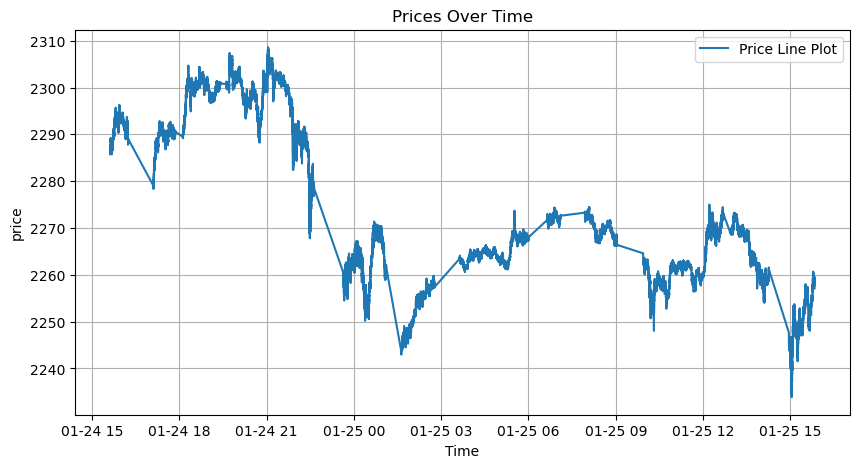

In [38]:
plot_price_line(test_BUT,'Price')

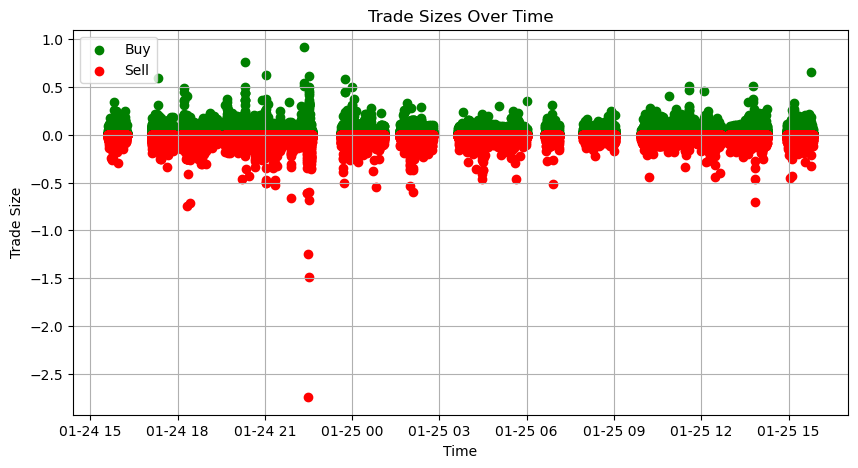

In [39]:
plot_trade_sizes(test_BUT, 'Size', 'Side')

#### 'ETH-BTC'

The ETH-BTC market has a lower price since the unit is in another crypto, we can tell that we have less data about it, therefore, we need to pay attention to the check interval we set in the later part. Maybe we should not close our position so frequently in the next part. The sudden drop in the price is also very obivious. In addition, since the unit of this one is quite special, when do analysis, we need to pay attention to that. 

In [40]:
test_EBT.describe()

,Price,Size,Side
count,1175.000000,1.175000e+03,1175.000000
mean,0.006886,8.367491e-02,-0.053617
std,0.000071,2.534562e-01,1.841140
min,0.006822,1.000000e-09,-28.000000
25%,0.006836,2.000000e-03,-1.000000
50%,0.006847,8.069695e-03,1.000000
75%,0.006967,8.000000e-02,1.000000
max,0.007056,3.758155e+00,11.000000


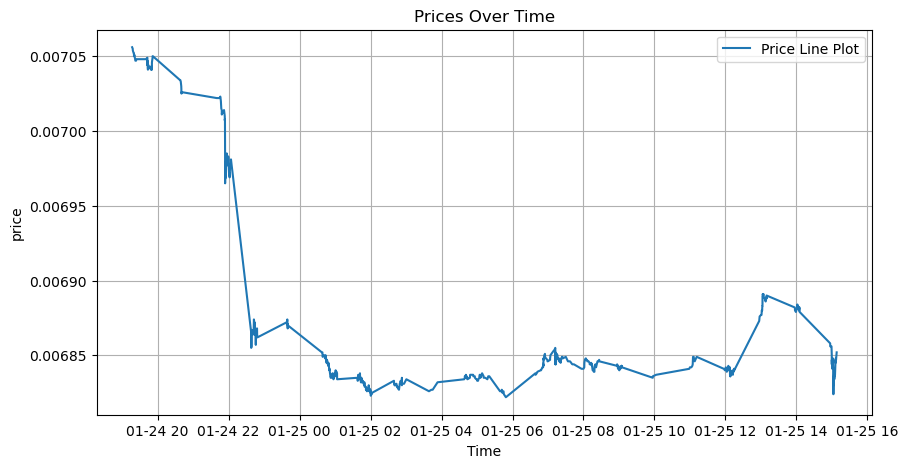

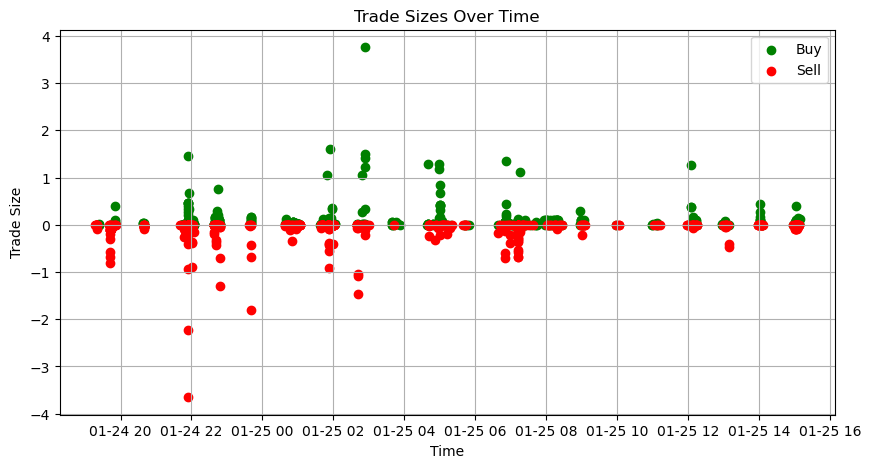

In [41]:
plot_price_line(test_EBT,'Price')
plot_trade_sizes(test_EBT, 'Size', 'Side')

#### 'ETH-USD'

For this one, we got more data than previous part, the outlier sell and buy order are also quite obvious. 

In [42]:
test_EUT.describe() 

,Price,Size,Side
count,226311.000000,2.263110e+05,226311.000000
mean,156.386055,7.219574e-02,0.053921
std,2.840021,2.411362e-01,1.312619
min,153.269000,1.000000e-09,-36.000000
25%,154.601000,3.092453e-03,-1.000000
50%,155.217000,1.847993e-02,1.000000
75%,156.422000,6.440509e-02,1.000000
max,162.501000,3.403621e+01,7.000000


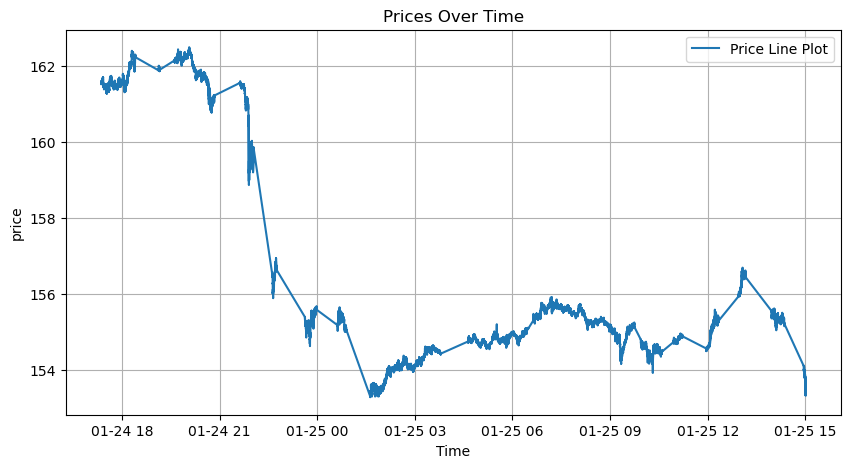

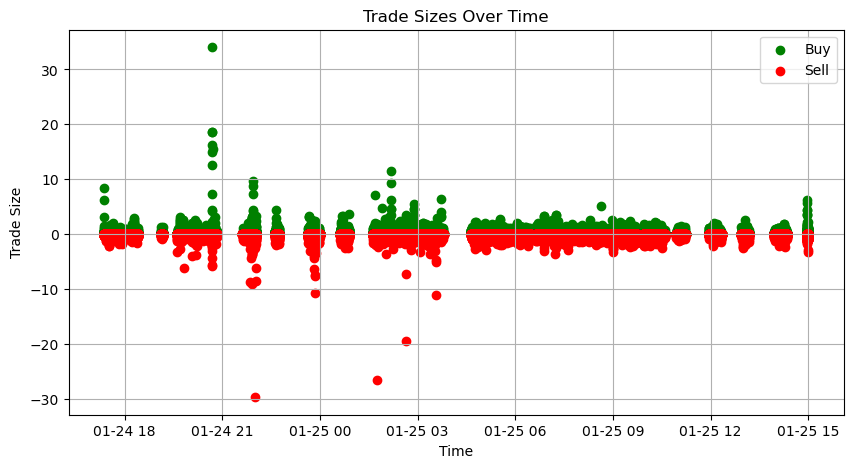

In [43]:
plot_price_line(test_EUT,'Price')
plot_trade_sizes(test_EUT, 'Size', 'Side')

### 4.2 Adjust parameters 

Here, we conduct the analysis regarding the parameters. The organization is not so good, I implement codes by checking changing in each parameter in all three pairs. 

In this part, I go thruogh teh adjustment regarding the parameters. I will set each parameter fixed after investigation. Deatiled findings and analysis are downbelow. 

Paramters we go through: 
* tau 
* T 
* j 
* check_interval 
* transaction cost (no code demonstration)
* size (no code demonstration)

#### 'BTC-USD'

**change in $\tau$ and T**

Here, I will test several situation. 
1) $\tau$ or T is small/ large
2) $\tau$ approaches T
3) $\tau$ is larger/smaller than T 

The result is quite anti-instinct, supposinly, with large T and smaller tau, we have weaker predictive power, therefore, we should expect a lower pnl in total, however, the result is contradicted with my initial guess. 

Also, it seems like the greater tau with short T does not really aid the predicting power if we think a greater pnl represents an increase in predictive power. However, if we check the sharpe ratio, the 50-10 pair gives the best result. From a practical point, when balancing all the aspects in the performance metrics, it seems like the 20-20 also works bettter. 

Some other issues shown in the study of tau and T are the beta varies a lot if we change the tau and T. In addition, there is some few outstanding size in the graph, largerly related to the pnl change. Some other parts found out in the study: we take a lot of tradings with this j-threshold, maybe taking too much. Here I set the trading cost as 0.0001 (percent calculation rule), which is very low. If we larger the trading cost, the frequent entering and existing the market will certainly lead to some issues. Also, if took a closer look to the tail and risk performance, we can see that all the strategies work poorly. The key problem is the size we taken depends on the bid size and ask size. Moreover, I did not set any stop loss level, which does not prevent us to go to the extreme. 

In [44]:
tau = [1,20,10,50,10] 
T = [1,20,10,10,50]

Beta: -0.00024349689819989077
trail 0


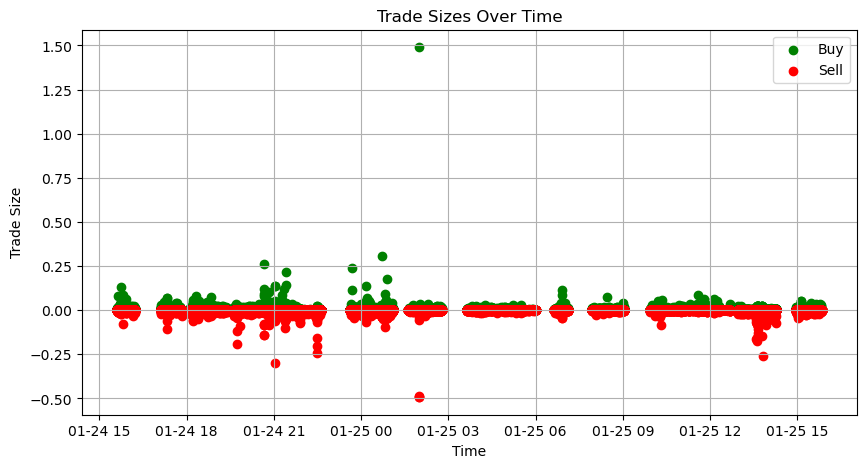

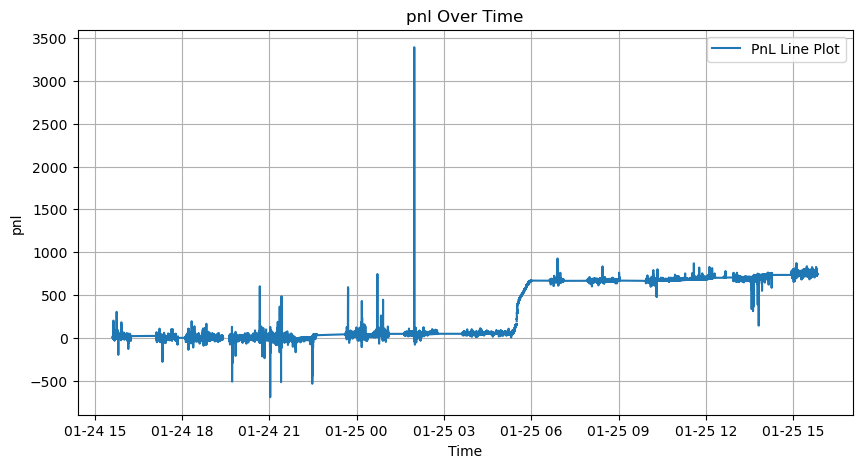

Beta: 8.312960524222542e-06
trail 1


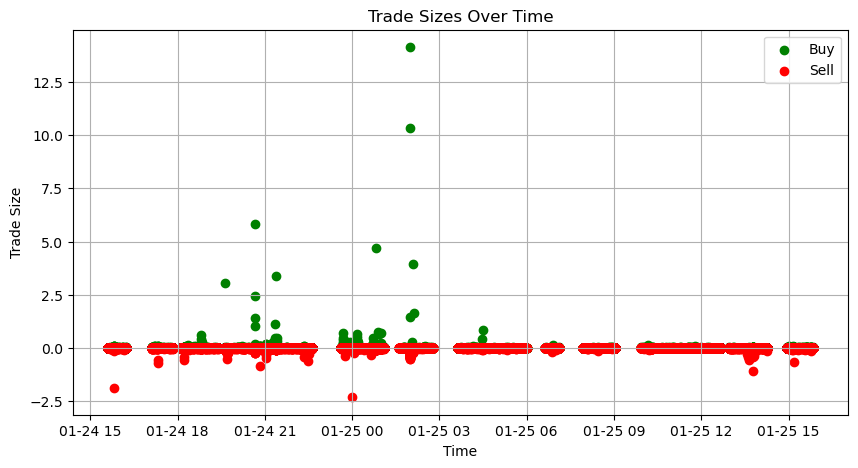

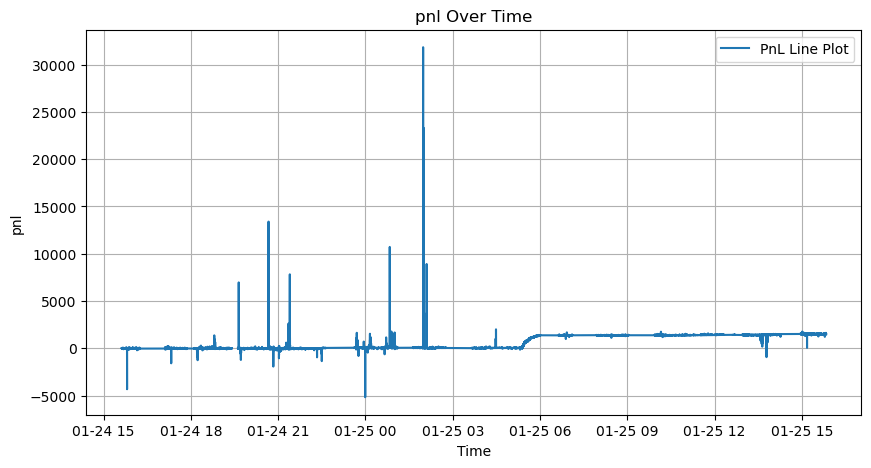

Beta: -2.7398100682961528e-05
trail 2


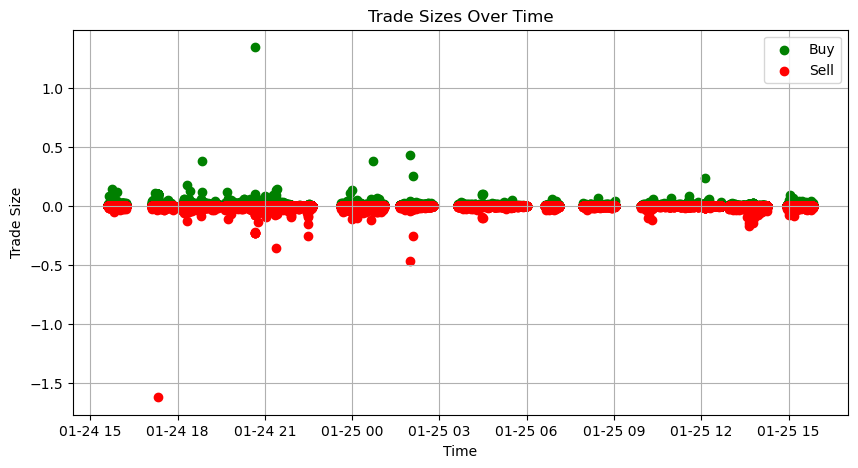

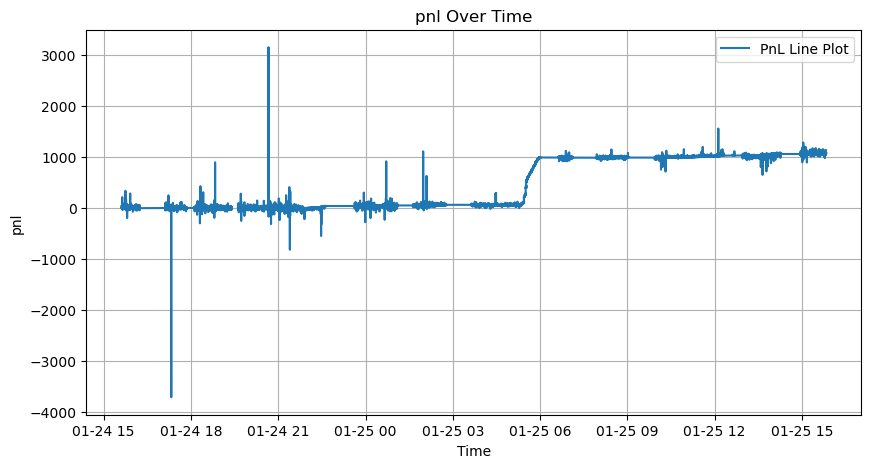

Beta: -6.256986251777043e-06
trail 3


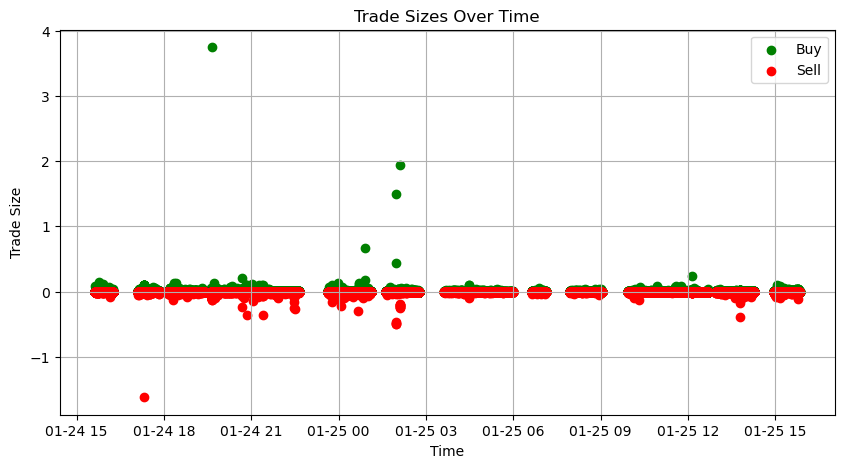

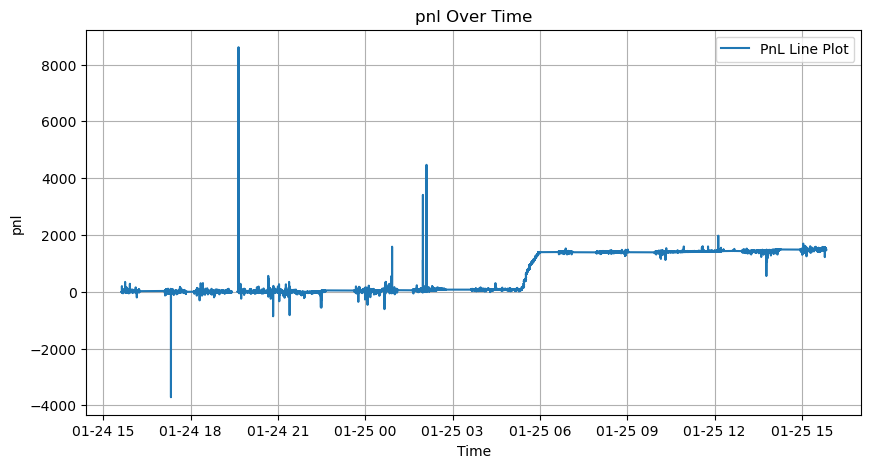

Beta: 4.3079575363958936e-05
trail 4


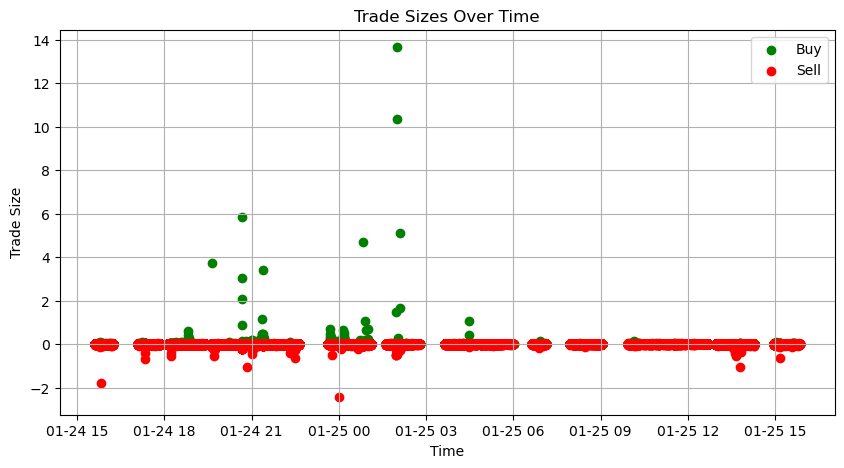

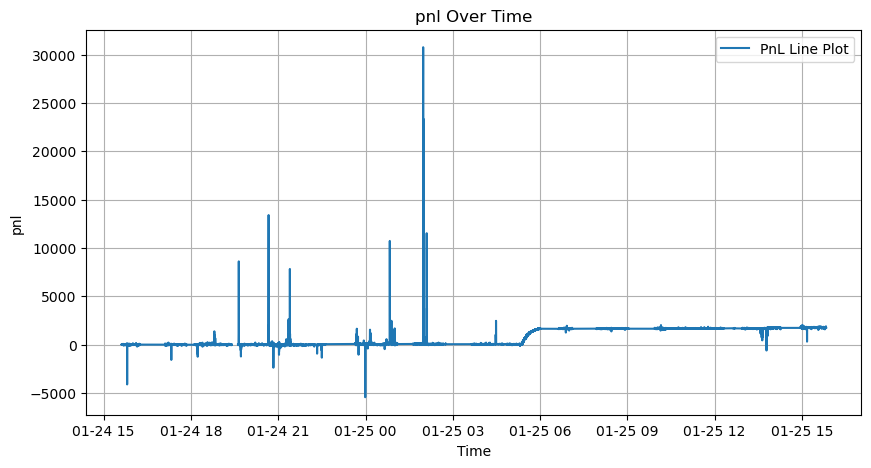

,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail0,0.000244,0.003382,0.000326,747.034761,0.749017,3474.876403,-0.000014,-0.000048,0.733685,-0.860441,0.803749,159.587422
trail1,0.000510,0.006815,0.000864,1504.009473,0.590870,32757.540382,-0.000030,-0.000150,9.217572,258.631198,0.844250,376.352171
trail2,0.000352,0.004841,0.000479,1068.834280,0.735572,4047.224654,-0.000020,-0.000062,0.674669,-0.946538,0.844219,183.454920
trail3,0.000494,0.006725,0.000674,1482.807813,0.732880,9474.275559,-0.000021,-0.000070,0.822651,0.320503,0.844238,216.198129
trail4,0.000600,0.007983,0.000958,1762.705706,0.626077,31362.326551,-0.000029,-0.000149,6.390735,149.168783,0.844219,383.495086


In [45]:
list_p = []
for i in range(len(tau)):
    t = strategy(test_BUT,train_BUT,train_BUB,test_BUB,tau[i],T[i],0,0.05,0.0001,5)
    t_1 = calculate_pnl_1(t,0.00001,show = -1)
    df = performance_summary(t_1, 'trail'+str(i))
    print('trail',i)
    plot_trade_sizes(t_1,'trade_amount','signal')
    plot_pnl_line(t_1,'total_pnl')
    list_p.append(df)
per1 = pd.concat(list_p)
per1

**j_threshold**

The 0 and 10e6 gives a similar result. It seems like if we ensure a larger than 60% trading rate, the more trading opportunity, the higher chances we will get a higher cumulatve pnl. However, this result also needs to be further tested. 

In [46]:
strategy(test_BUT,train_BUT,train_BUB,test_BUB,50,10,0.00001,1,0.01,5)['predict_return'].quantile([0.25, 0.5, 0.75])


Beta: -6.256986251777043e-06


0.25   -2.528315e-06
0.50   -5.909902e-08
0.75    2.413124e-06
Name: predict_return, dtype: float64

In [47]:
j_1 = [0,10e-9,1e-6]

In [48]:
list_p_1 = []
for i in range(len(j_1)):
    t = strategy(test_BUT,train_BUT,train_BUB,test_BUB,50,10,j_1[i],1,0.001,5)
    t_1 = calculate_pnl_1(t,0.001,show = -1)
    df = performance_summary(t_1, 'trail'+str(i))
    #print('trail',i)
    #plot_trade_sizes(t_1,'trade_amount','signal')
    #plot_pnl_line(t_1,'total_pnl')
    list_p_1.append(df)
per2 = pd.concat(list_p_1)
per2

Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06


,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail0,0.004792,0.090320,0.011355,19914.105651,0.422021,190486.820175,-0.005438,-0.006104,0.894275,2.385890,0.844238,4323.962582
trail1,0.004796,0.090354,0.011357,19921.561750,0.422350,190486.106193,-0.005432,-0.006099,0.894246,2.383396,0.842220,4318.181759
trail2,0.002230,0.051658,0.007202,11389.797997,0.309699,190158.232898,-0.004412,-0.005120,1.712564,23.736839,0.650437,3481.933240


**interval check**

A short period of checking/ closing position will lead to no trading at all. The trading rate increases while we increase our close interval. Leading to a higher cumulative pnl but also a higher max-drawdown. Here, I set the trading cost relatively low, so the frequent trading does not influence must but if i increase the trading cost, the cumulative pnl turns to extreme negative. 

In [49]:
check = [1,5,10,50,100]

In [50]:
list_p_3 = []
for i in range(len(check)):
    t = strategy(test_BUT,train_BUT,train_BUB,test_BUB,50,10,0,1,0.001,check[i])
    t_1 = calculate_pnl_1(t,0.001,show = -1)
    df = performance_summary(t_1, 'trail'+str(i))
    #print('trail',i)
    #plot_trade_sizes(t_1,'trade_amount','signal')
    #plot_pnl_line(t_1,'total_pnl')
    list_p_3.append(df)
per3 = pd.concat(list_p_3)
per3

Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06


,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail0,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
trail1,0.004792,0.090320,0.011355,19914.105651,0.422021,190486.820175,-0.005438,-0.006104,0.894275,2.385890,0.844238,4323.962582
trail2,0.006679,0.117540,0.014319,25915.621230,0.466449,200569.728595,-0.005681,-0.007493,0.728723,0.401906,0.918303,4745.433315
trail3,0.006748,0.117057,0.015152,25808.997312,0.445313,225468.402658,-0.008256,-0.014026,0.856059,4.234728,0.971134,4736.941975
trail4,0.008222,0.133785,0.016984,29497.333703,0.484092,227845.815764,-0.009418,-0.016305,0.678712,2.314497,0.983583,4615.970602


In [51]:
list_p_3 = []
for i in range(len(check)):
    t = strategy(test_BUT,train_BUT,train_BUB,test_BUB,50,10,0,1,0.01,check[i])
    t_1 = calculate_pnl_1(t,0.01,show = -1)
    df = performance_summary(t_1, 'trail'+str(i))
    #print('trail',i)
    #plot_trade_sizes(t_1,'trade_amount','signal')
    #plot_pnl_line(t_1,'total_pnl')
    list_p_3.append(df)
per3 = pd.concat(list_p_3)
per3

Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06
Beta: -6.256986251777043e-06


,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail0,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
trail1,-0.041508,-0.311362,0.020312,-68649.990808,-2.043454,226497.594374,-0.067143,-0.068166,0.731463,-0.105779,0.844238,4323.962582
trail2,-0.044117,-0.323307,0.021567,-71283.694496,-2.045618,236282.820116,-0.071934,-0.073992,0.706273,-0.126915,0.918303,4745.433315
trail3,-0.043889,-0.323113,0.022707,-71240.894768,-1.932807,248923.986334,-0.072749,-0.075043,0.793119,0.909034,0.971134,4736.941975
trail4,-0.041124,-0.295046,0.021749,-65052.590426,-1.890875,250785.724938,-0.070211,-0.072923,0.745076,1.193438,0.983583,4615.970602


**trading cost & size**

Since trading cost increases, leading to the lower pnl is a rule. I did not try to change the trading cost parameters. 

Similar reason for the size, it amplifies and shrinks the orginal cumulative pnl, but does not influence other parts of calculation. 


#### 'ETH-BTC'

**change in $\tau$ and T**

In this section, it seems like trail 0 (1-1) pair and trail 3 (50-10) gives the best result. I think it is diretcly related to the size of the market. The available data here is fewer. Therefore, a shorter range will give a better result. For the 50-10 pair, it seems to prove the predictive power increased when we increase tau. The last trail (10-50) matches our initial assumption, suggesting that the previous one might be an outlier/ a special case. We can definitely double test in for another pair. 

For this section, I should convert all the calculation in the USD in order to match another two pair. But, the change in unit needs to refine the strategy function, here, I did not do that. I will improve it later. In addition, I adapt findings from previous parts. I increase the trading cost to add penalty for frequent entering. I also increase the size just to make the pnl result larger for calculation purpose. 

Beta: -0.0010553773623882717
trail 0


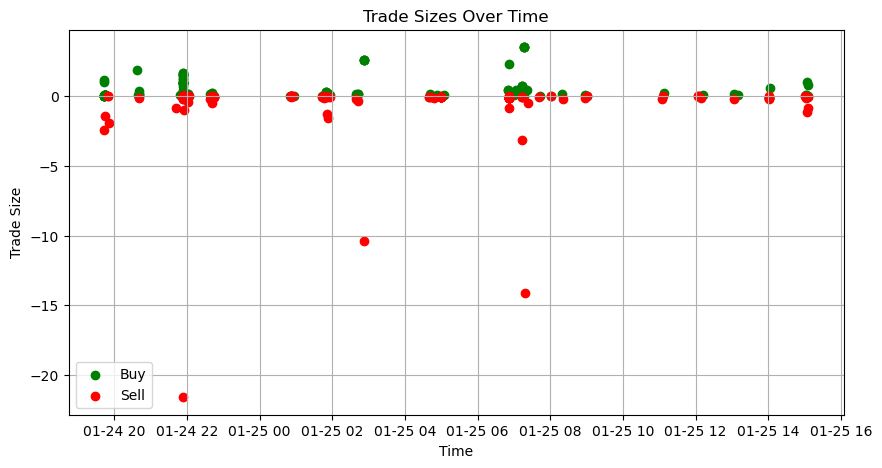

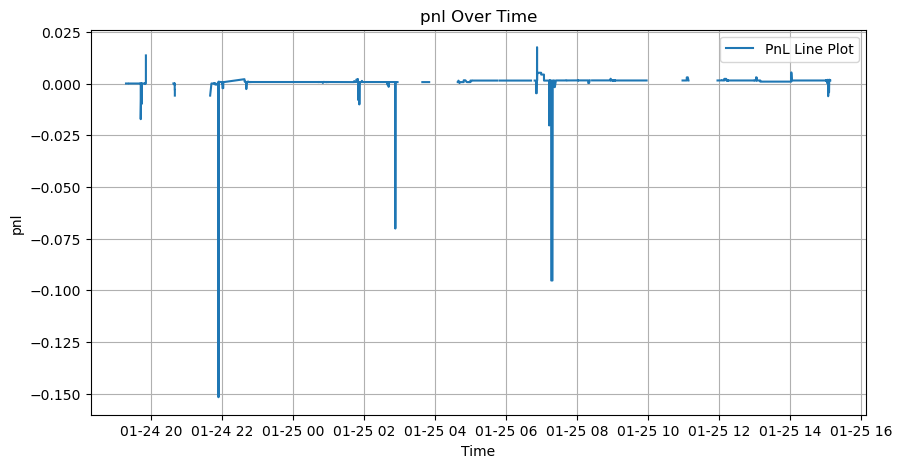

Beta: -0.00019336745767566487
trail 1


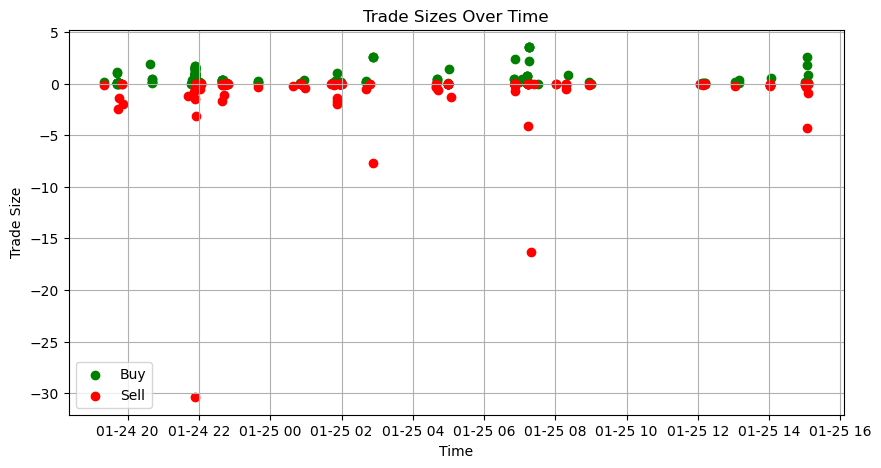

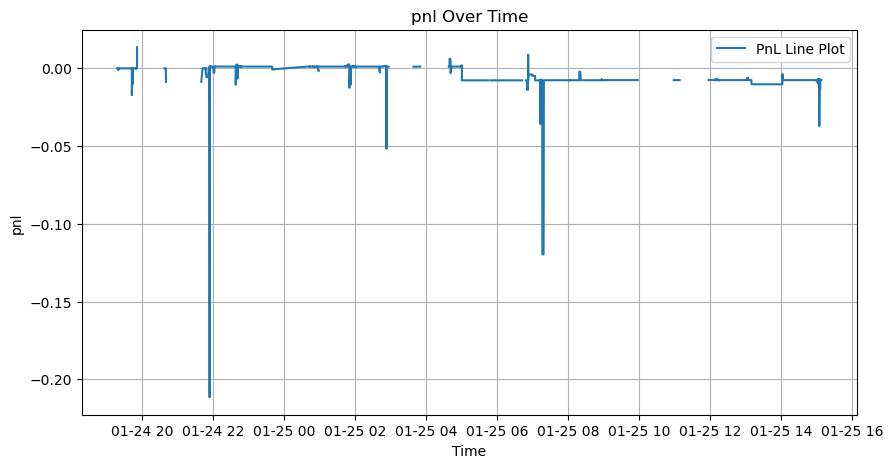

Beta: -0.0009439208987424974
trail 2


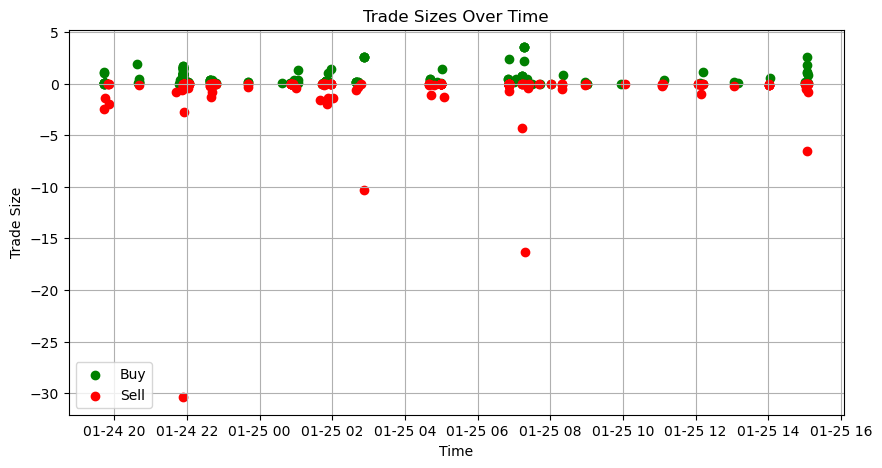

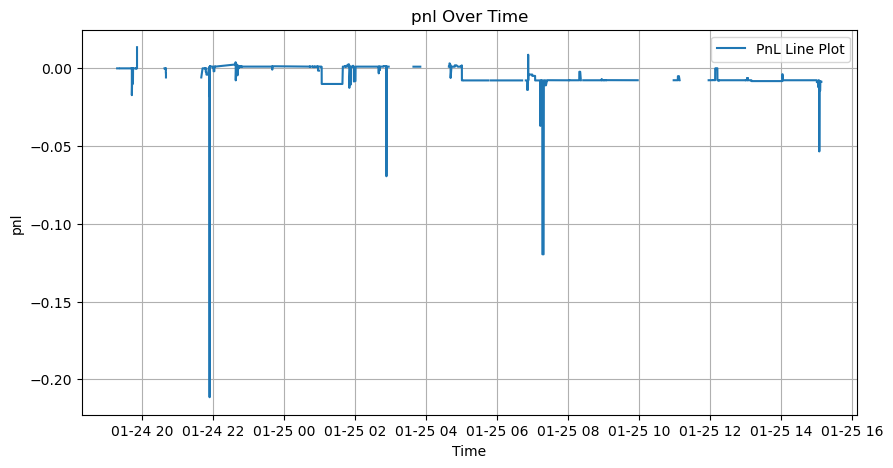

Beta: -0.0008069308733603728
trail 3


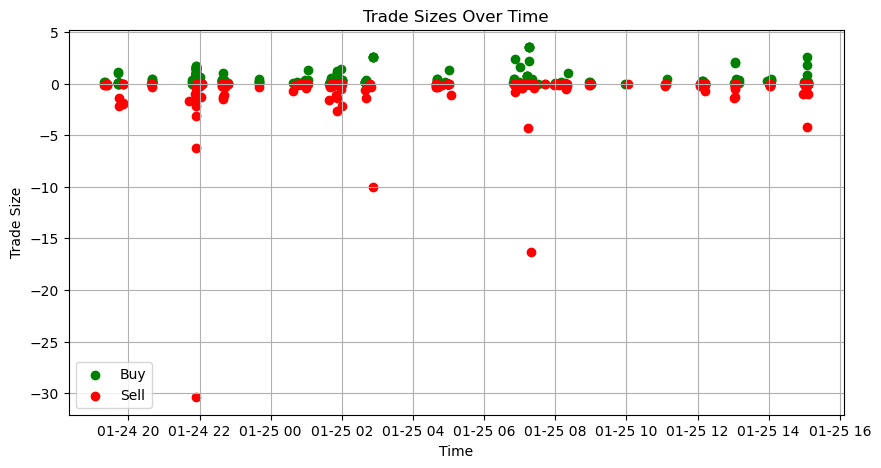

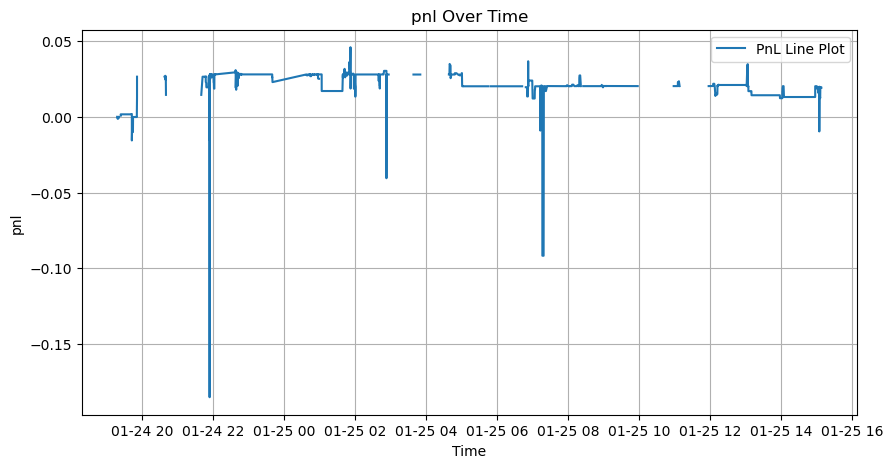

Beta: -0.0008023724581579817
trail 4


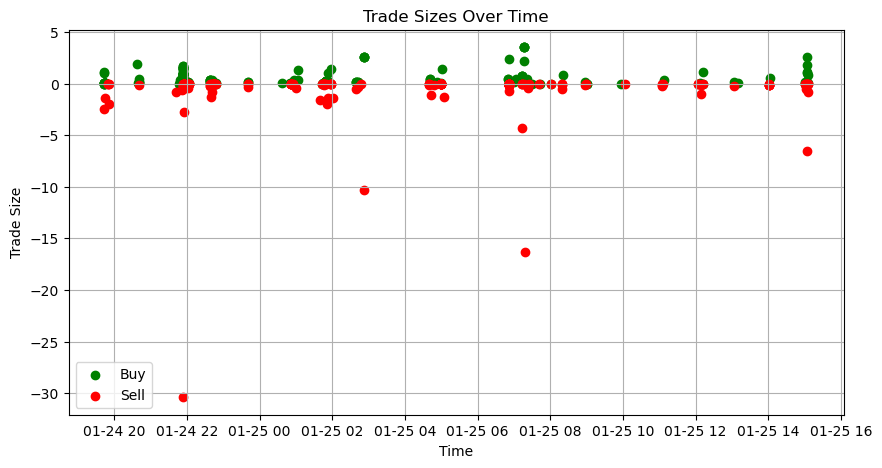

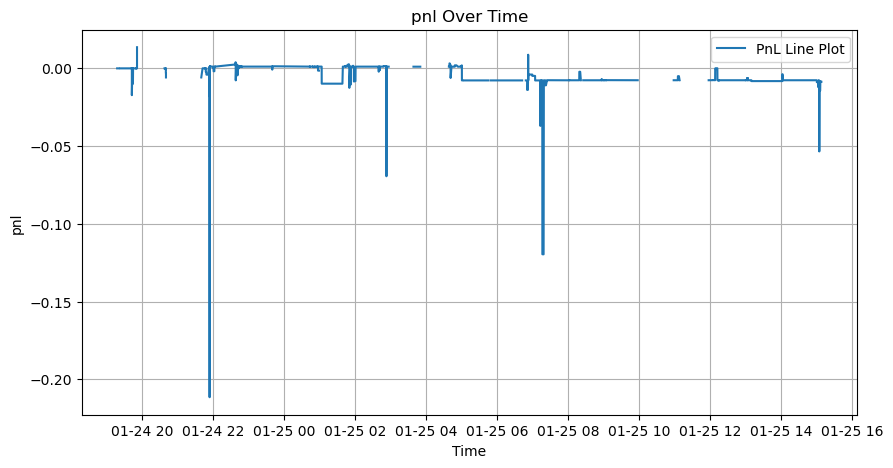

,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail0,-3.853894e-09,0.000001,2.300624e-08,0.001460,-0.167515,0.165307,-1.014496e-08,-8.803149e-08,0.0,0,0.313922,142.274263
trail1,-7.663534e-09,-0.000007,2.536597e-08,-0.007552,-0.302119,0.225095,-1.679943e-08,-9.783729e-08,0.0,0,0.419472,196.522519
trail2,-7.950391e-09,-0.000008,2.546791e-08,-0.008651,-0.312173,0.225096,-1.731755e-08,-9.962499e-08,0.0,0,0.449500,211.092682
trail3,1.667788e-08,0.000018,2.613222e-08,0.019202,0.638211,0.212094,-6.687836e-09,-7.504208e-08,0.0,0,0.636033,264.993971
trail4,-7.945424e-09,-0.000008,2.546909e-08,-0.008651,-0.311963,0.225096,-1.731755e-08,-9.962480e-08,0.0,0,0.444040,210.706640


In [52]:
list_p = []
for i in range(len(tau)):
    t = strategy(test_EBT,train_EBT,train_EBB,test_EBB,tau[i],T[i],0.00001,1,0.01,5)
    t_1 = calculate_pnl_1(t,0.00001,show = -1)
    df = performance_summary(t_1, 'trail'+str(i))
    print('trail',i)
    plot_trade_sizes(t_1,'trade_amount','signal')
    plot_pnl_line(t_1,'total_pnl')
    list_p.append(df)
per1 = pd.concat(list_p)
per1

**j_threshold**

Here, I use the predictive return to get the quantile to construct three j_threshold. There might be some problem with the return parameter, since it is calculated without using the initial capital. I will focus on the cumulative pnl for analysis. j = 10e-8, lead to higher trading rate, a higher cumulative pnl. It may due to the fact that 10e-8 is closer to the mean. It seems like despite the trading cost, more participation in the market lead to higher pnl. I will further investigate the result. I also put the plot for the best result down below. 

In [53]:
strategy(test_EBT,train_EBT,train_EBB,test_EBB,50,10,0.00001,1,0.01,5)['predict_return'].quantile([0.25, 0.5, 0.75])

Beta: -0.0008069308733603728


0.25   -8.795905e-05
0.50    8.326893e-07
0.75    1.984745e-04
Name: predict_return, dtype: float64

In [54]:
j_1 = [0,10e-8,1e-4]

In [55]:
list_p_1 = []
for i in range(len(j_1)):
    t = strategy(test_EBT,train_EBT,train_EBB,test_EBB,50,10,j_1[i],1,0.001,5)
    t_1 = calculate_pnl_1(t,0.001,show = -1)
    df = performance_summary(t_1, 'trail'+str(i))
    #print('trail',i)
    #plot_trade_sizes(t_1,'trade_amount','signal')
    #plot_pnl_line(t_1,'total_pnl')
    list_p_1.append(df)
per2 = pd.concat(list_p_1)
per2

Beta: -0.0008069308733603728
Beta: -0.0008069308733603728
Beta: -0.0008069308733603728


,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail0,9.688642e-09,0.000005,2.618206e-08,0.005787,0.370049,0.214967,-1.339105e-08,-8.005845e-08,0.0,0,0.778890,317.417417
trail1,1.183719e-08,0.000011,2.593776e-08,0.011505,0.456369,0.213732,-1.032164e-08,-7.856560e-08,0.0,0,0.745223,310.419209
trail2,4.562651e-09,0.000005,2.495763e-08,0.004900,0.182816,0.211796,-8.322789e-09,-8.299068e-08,0.0,0,0.423112,203.502157


#### 'ETH-USD'

**change in $\tau$ and T**

For this one, the same observation appears the trail3, 50-10, gives the best result and shows the predictive power. 

Beta: -7.12011737743186e-06
trail 0


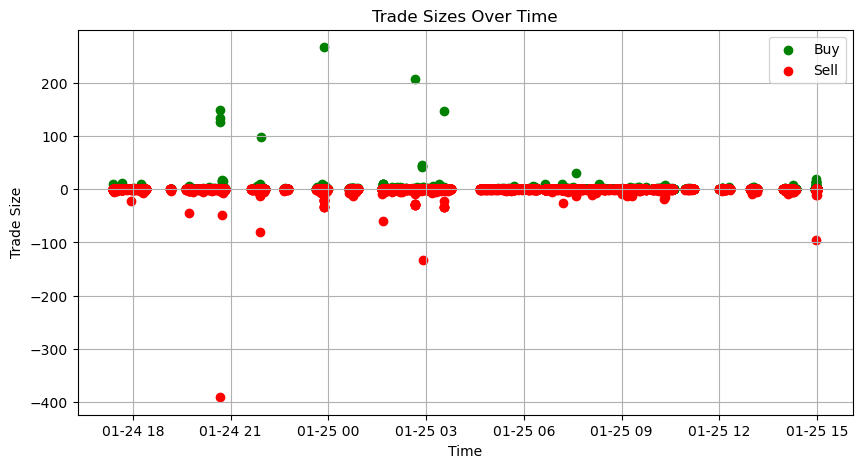

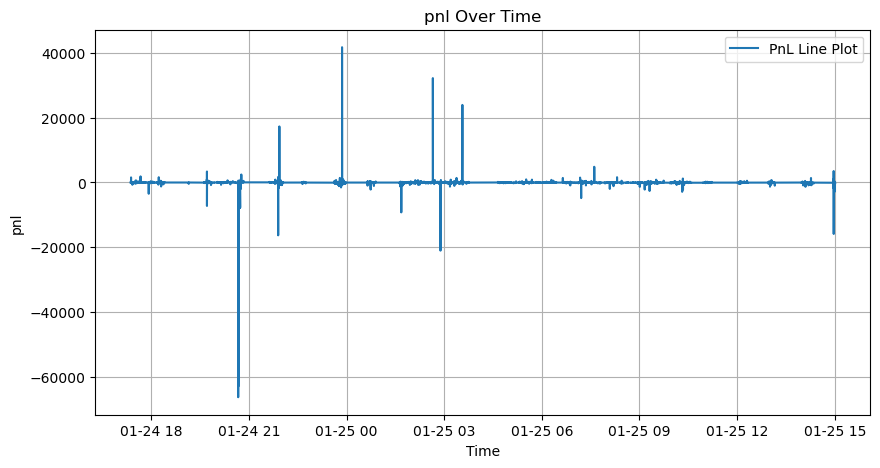

Beta: -5.012348367631763e-06
trail 1


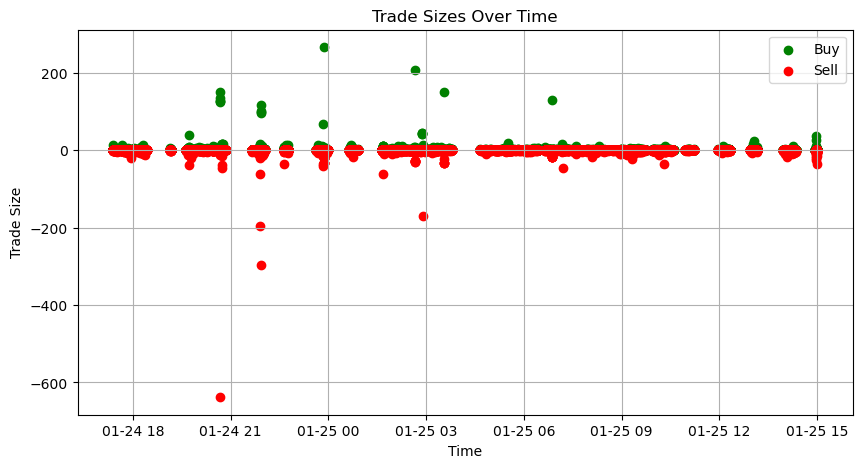

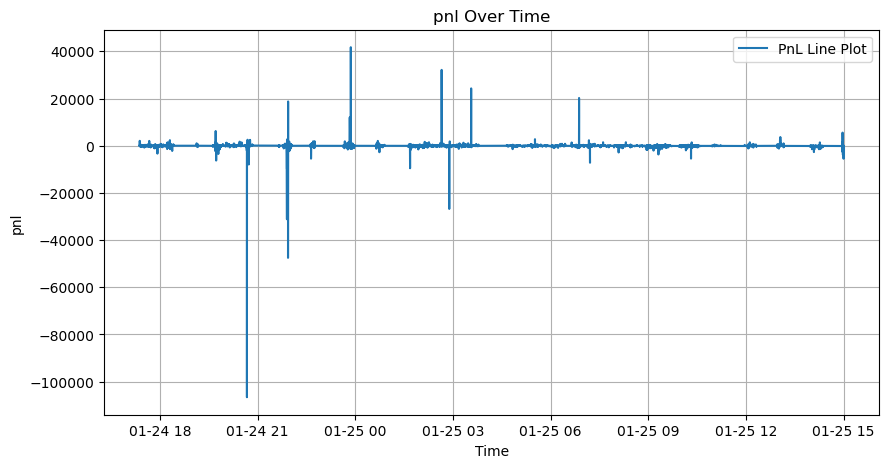

Beta: -5.622117855932402e-06
trail 2


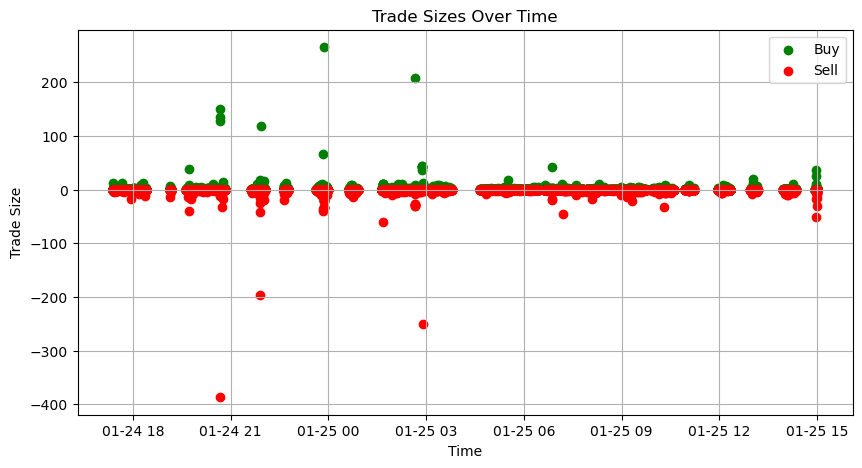

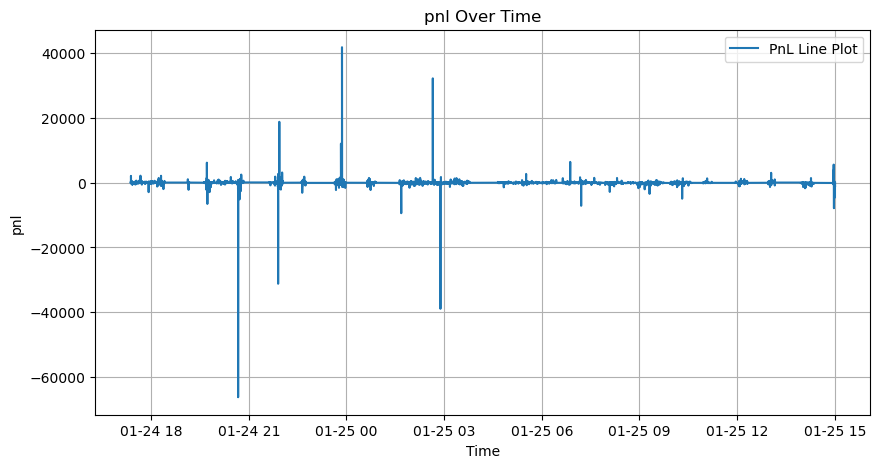

Beta: -1.5395854451061539e-06
trail 3


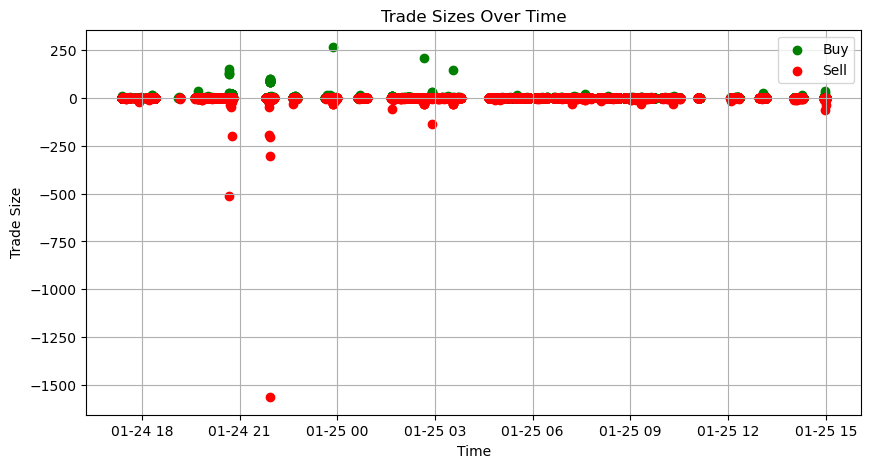

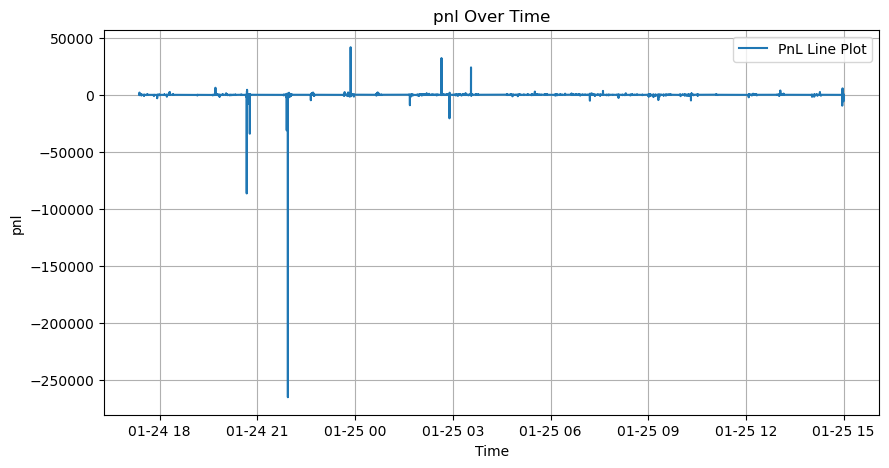

Beta: -4.7923898974865155e-06
trail 4


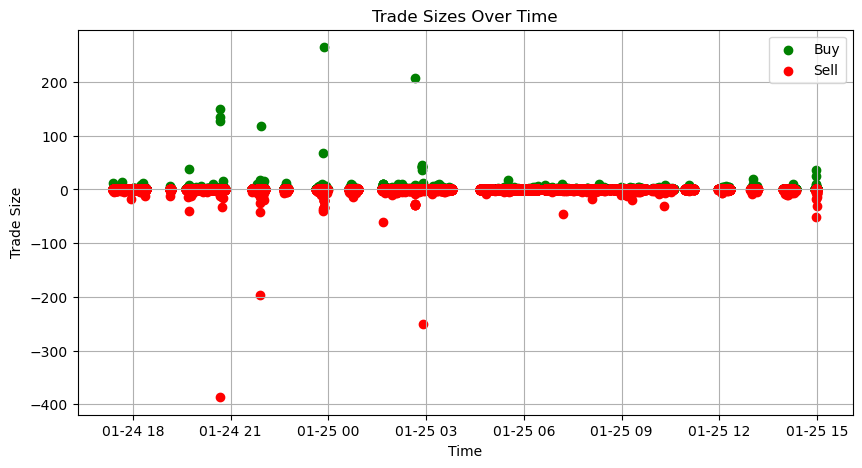

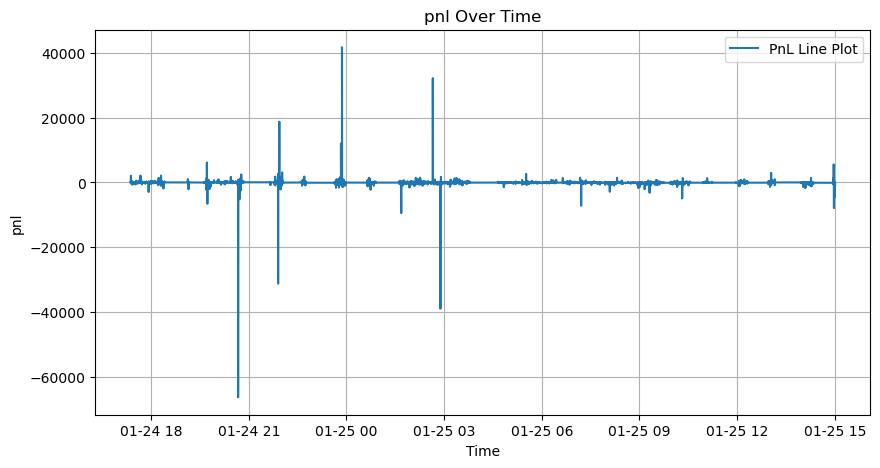

,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail0,-0.000091,-0.000285,0.001922,-43.104056,-0.047113,69580.855333,-0.000126,-0.002188,-19.455364,764.408309,0.109235,7332.560128
trail1,-0.000146,-0.000577,0.002852,-87.295989,-0.051296,112860.085784,-0.000368,-0.003243,-27.569256,1017.734372,0.409423,17427.274711
trail2,-0.000140,-0.000671,0.002086,-101.423625,-0.066920,80659.300186,-0.000324,-0.002749,-17.759120,586.847955,0.312972,13187.079148
trail3,-0.000376,0.000348,0.009299,52.548379,-0.040447,271617.856620,-0.000145,-0.009389,-25.927897,704.657060,0.224116,15778.819901
trail4,-0.000135,-0.000608,0.002084,-91.962720,-0.064629,80584.971793,-0.000298,-0.002706,-17.838692,589.797325,0.274901,12066.574878


In [56]:
list_p = []
for i in range(len(tau)):
    t = strategy(test_EUT,train_EUT,train_EUB,test_EUB,tau[i],T[i],0.00001,1,0.01,5)
    t_1 = calculate_pnl_1(t,0.00001,show = -1)
    df = performance_summary(t_1, 'trail'+str(i))
    print('trail',i)
    plot_trade_sizes(t_1,'trade_amount','signal')
    plot_pnl_line(t_1,'total_pnl')
    list_p.append(df)
per1 = pd.concat(list_p)
per1

**j_threshold**

This part's results are all work poorly, may due to the fact that the range of this part predictive return is larger, and the abover 0 j -threshold lead to a frequent entering and here the realized pnl does not support this high frequency trading. 

In [57]:
strategy(test_EUT,train_EUT,train_EUB,test_EUB,50,10,0.00001,1,0.01,5)['predict_return'].quantile([0.25, 0.5, 0.75])

Beta: -1.5395854451061539e-06


0.25   -4.575145e-06
0.50    3.129399e-07
0.75    5.838093e-06
Name: predict_return, dtype: float64

In [58]:
j_1 = [0,10e-7,1e-6]

In [59]:
list_p_1 = []
for i in range(len(j_1)):
    t = strategy(test_EUT,train_EUT,train_EUB,test_EUB,50,10,j_1[i],1,0.001,5)
    t_1 = calculate_pnl_1(t,0.001,show = -1)
    df = performance_summary(t_1, 'trail'+str(i))
    #print('trail',i)
    #plot_trade_sizes(t_1,'trade_amount','signal')
    #plot_pnl_line(t_1,'total_pnl')
    list_p_1.append(df)
per2 = pd.concat(list_p_1)
per2

Beta: -1.5395854451061539e-06
Beta: -1.5395854451061539e-06
Beta: -1.5395854451061539e-06


,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
trail0,-0.003843,-0.036694,0.012078,-5546.204341,-0.318153,353537.640682,-0.005382,-0.016479,-25.367890,685.285569,0.845145,35568.403680
trail1,-0.003444,-0.033190,0.009565,-5016.574685,-0.360107,273039.489863,-0.004863,-0.014164,-23.748935,610.926130,0.747992,32074.035947
trail2,-0.003444,-0.033190,0.009565,-5016.574685,-0.360107,273039.489863,-0.004863,-0.014164,-23.748935,610.926130,0.747992,32074.035947


### 4.3 reliability/stability of β

Form the graph, we can see some sudden increase and decrease in beta, but all the adf test states that beta is stationary. I should conduct different periods experiment. 

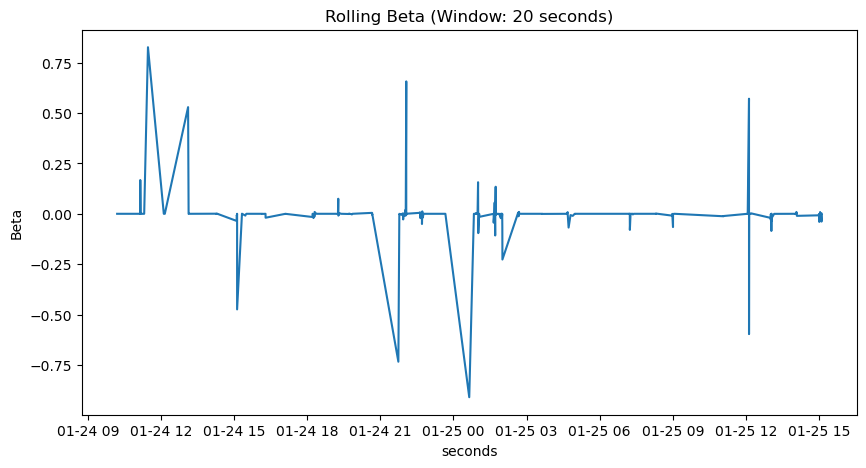

In [60]:
b1 = calculate_rolling_beta(ETH_BTC_B,ETH_BTC_T,20)

In [61]:
adf_test(b1,'ETH-BTC')

Augmented Dickey-Fuller Test: ETH-BTC
ADF Test Statistic: -29.473219376643833
p-value: 0.0
# Lags Used: 0
# Observations Used: 868
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


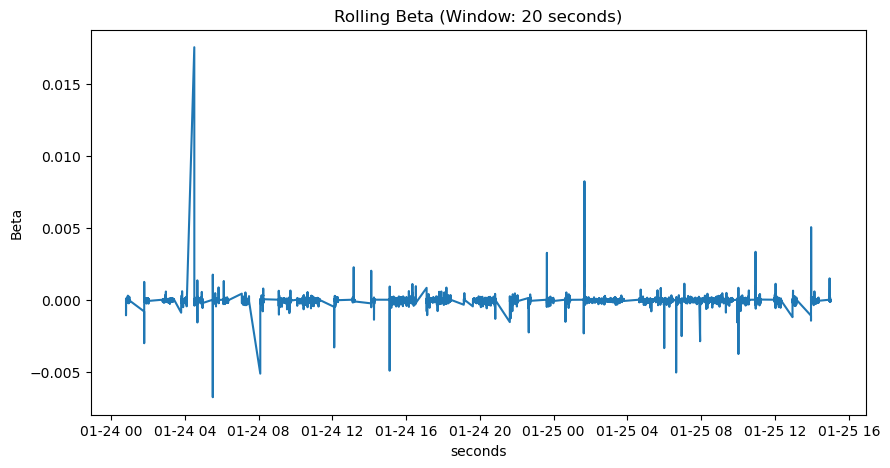

In [62]:
b2 = calculate_rolling_beta(ETH_USD_B,ETH_USD_T,20)

In [63]:
adf_test(b2,'ETH-USD')

Augmented Dickey-Fuller Test: ETH-USD
ADF Test Statistic: -59.21794428280116
p-value: 0.0
# Lags Used: 38
# Observations Used: 376700
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


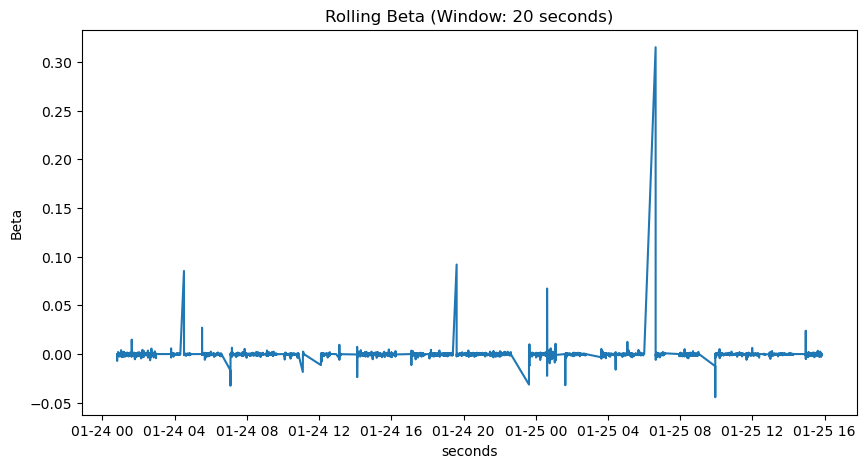

In [64]:
b3 = calculate_rolling_beta(BTC_USD_B,BTC_USD_T,20)

In [65]:
adf_test(b3,'BTC-USD')

Augmented Dickey-Fuller Test: BTC-USD


ADF Test Statistic: -508.5833584288135
p-value: 0.0
# Lags Used: 1
# Observations Used: 553135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### 4.4 General analysis of trading performance 

I will give a general analysis regarding trading performance for one of the better performanced strategy. 

Mean Return (0.004796): It suggests that on average, each trade is profitable, which is a good sign for the strategy's effectiveness.

Mean PnL (0.090354): This is the average profit and loss per trade. We have a small gain after considering the transaction cost. 

Volatility (0.011357): The relatively low volatility here suggests that the returns of the strategy are fairly stable.

Cumulative PnL (19921.56175): The cumulative PNL is not so high considering we have conducted a lot trade. 

Sharpe Ratio (0.42235): The sharpe ratio looks good but it used 0 as benchmark, if utilizing risk-free rate or market factor, situation may be different. 

Max Drawdown (190486.1093): The magnitude of the max drawdown here is quite substantial and should be carefully considered.

VaR (Value at Risk) (-0.005432): A negative VaR suggests a potential loss and a higher risk. 

CVaR (Conditional Value at Risk) (-0.006099): Similar as VaR, here it suggests the risk of loss. 

Skewness (0.894246):it shows that we have more frequent large positive returns than negative ones.

Kurtosis (2.383396): it indicates more extreme positive or negative returns.

Trading Rate (0.84222): Here, we have a very high trading rate, which is very dangerous. 


Though it does not represent all the situations we analyzed before. It represents a common trend, all the strategies have a tail risk and potential loss. The var and Cvar are not good generally. 

In [66]:
op = strategy(test_BUT,train_BUT,train_BUB,test_BUB,50,10,10e-9,1,0.001,5)
op_per = calculate_pnl_1(op,0.001,show=-1)
calculate_pnl_1(op,0.001,show=1)

Beta: -6.256986251777043e-06


,trade_price,trade_amount,trade_position,position,trade_cost,realized_pnl,unrealized_pnl,total_pnl,return
timestamp_utc_nanoseconds,,,,,,,,,
2023-01-24 15:37:42.650584,2287.134,0.004400,-0.004400,-0.004400,0.010063,10.053326,-0.000266,10.053060,0.000010
2023-01-24 15:37:42.785083,2287.135,0.004400,-0.004400,-0.008800,0.010063,10.053331,-0.000519,20.106138,0.000020
2023-01-24 15:37:42.785249,2287.135,0.004400,-0.004400,-0.013200,0.010063,10.053331,-0.000792,30.159195,0.000030
2023-01-24 15:37:42.789155,2287.193,0.003819,-0.003819,-0.017019,0.008735,8.726055,-0.000528,38.885515,0.000039
2023-01-24 15:37:42.797303,2287.193,0.003819,-0.003819,-0.020838,0.008735,8.726055,-0.001323,47.610775,0.000048
...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,2257.308,0.000171,0.000171,0.099975,0.000386,-0.386221,-0.005549,19696.210758,0.019696
2023-01-25 15:50:01.543105,2257.250,0.000311,0.000311,0.100286,0.000703,-0.703511,-0.007923,19695.504873,0.019696
2023-01-25 15:50:01.601688,2257.193,0.007646,0.007646,0.107932,0.017258,-17.275756,-0.005451,19678.231589,0.019678


In [67]:
performance_summary(op_per,'op_per')

,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
op_per,0.004796,0.090354,0.011357,19921.56175,0.42235,190486.106193,-0.005432,-0.006099,0.894246,2.383396,0.84222,4318.181759


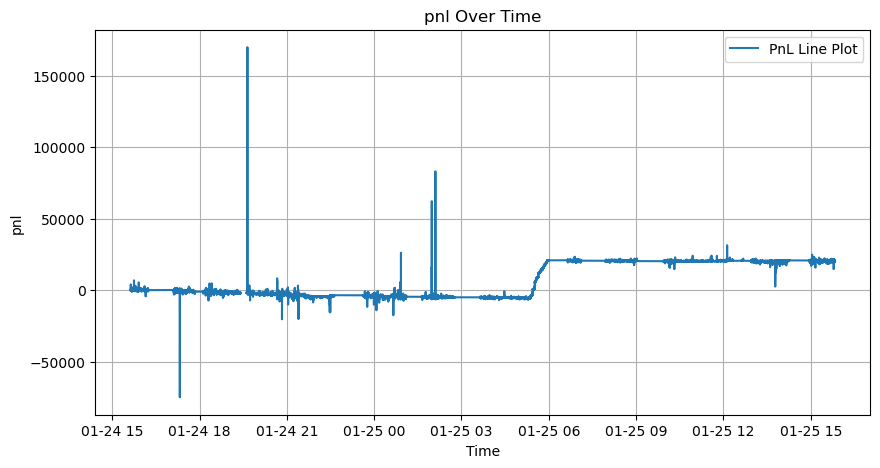

In [68]:
plot_pnl_line(op_per,'total_pnl')

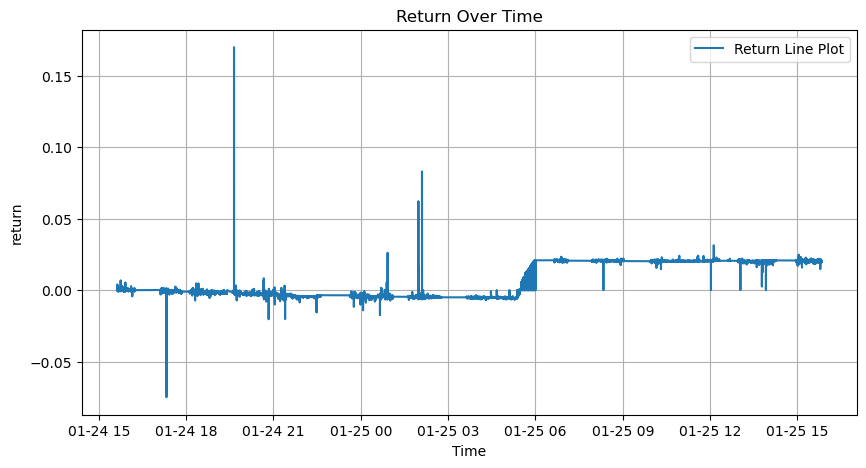

In [69]:
plot_ret_line(op_per,'return')

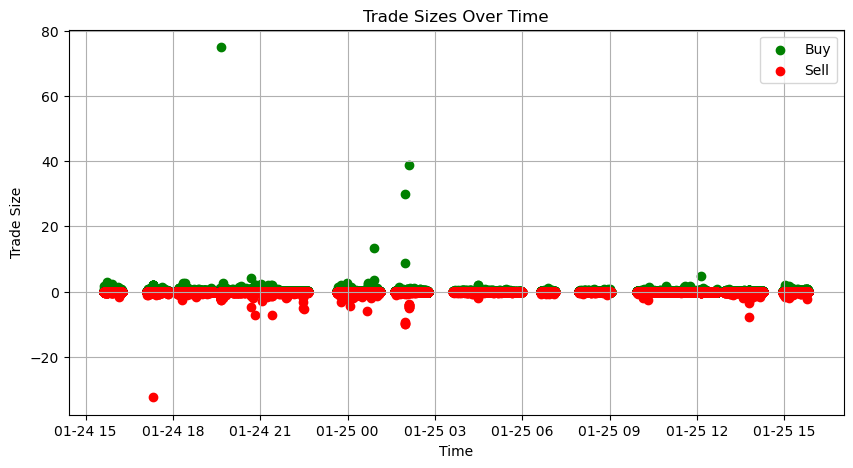

In [70]:
plot_trade_sizes(op_per,'trade_amount','signal')

### 4.5 Optimization 

Using optuna, I can get a slight better result, but there is no siginificant improvement. 

In [71]:
import optuna

In [72]:
def objective(trial):
    tau = trial.suggest_int('tau', 5, 50)  
    T = trial.suggest_int('T', 5, 50) 
    j = trial.suggest_float('j',0,5e-4)
    check = trial.suggest_int('check',1,50)

    a = strategy(test_BUT,train_BUT,train_BUB,test_BUB,tau,T,j,1,0.001,check)
    b = calculate_pnl_1(a,0.001,show=-1)
    pnl = b['total_pnl'][-1]
    return pnl

In [76]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f"Best parameters: {study.best_params}")

[I 2024-02-08 22:07:10,907] A new study created in memory with name: no-name-3b603bfa-d951-47a6-9eee-06b3962d6a1a


Beta: 3.9605662430077776e-05


[I 2024-02-08 22:07:11,554] Trial 0 finished with value: 0.0 and parameters: {'tau': 13, 'T': 40, 'j': 0.0003807896544156948, 'check': 21}. Best is trial 0 with value: 0.0.


Beta: -4.456374603484667e-06


[I 2024-02-08 22:07:12,200] Trial 1 finished with value: 0.0 and parameters: {'tau': 28, 'T': 23, 'j': 0.00047006298411141355, 'check': 50}. Best is trial 0 with value: 0.0.


Beta: 9.731769046008825e-06


[I 2024-02-08 22:07:12,849] Trial 2 finished with value: 0.0 and parameters: {'tau': 48, 'T': 33, 'j': 0.0001834296504428193, 'check': 24}. Best is trial 0 with value: 0.0.


Beta: -2.3869265044520044e-05


[I 2024-02-08 22:07:13,491] Trial 3 finished with value: 0.0 and parameters: {'tau': 25, 'T': 5, 'j': 0.00043596946121127715, 'check': 20}. Best is trial 0 with value: 0.0.


Beta: -1.3877123757519168e-06


[I 2024-02-08 22:07:14,130] Trial 4 finished with value: 0.0 and parameters: {'tau': 8, 'T': 9, 'j': 0.0002515091115619352, 'check': 5}. Best is trial 0 with value: 0.0.


Beta: 2.9510330524928523e-06


[I 2024-02-08 22:07:14,790] Trial 5 finished with value: 0.0 and parameters: {'tau': 36, 'T': 29, 'j': 0.00037192509079726646, 'check': 41}. Best is trial 0 with value: 0.0.


Beta: -2.5965818644612416e-05


[I 2024-02-08 22:07:15,458] Trial 6 finished with value: 38.92369282091431 and parameters: {'tau': 13, 'T': 37, 'j': 3.444233019138698e-05, 'check': 42}. Best is trial 6 with value: 38.92369282091431.


Beta: -5.5497372329127566e-05


[I 2024-02-08 22:07:16,090] Trial 7 finished with value: -409.93606402612016 and parameters: {'tau': 23, 'T': 16, 'j': 3.557921833869016e-05, 'check': 16}. Best is trial 6 with value: 38.92369282091431.


Beta: 1.2572205127120621e-05


[I 2024-02-08 22:07:16,727] Trial 8 finished with value: 0.0 and parameters: {'tau': 33, 'T': 25, 'j': 0.0003221936862643599, 'check': 44}. Best is trial 6 with value: 38.92369282091431.


Beta: -3.908022024585788e-06


[I 2024-02-08 22:07:17,361] Trial 9 finished with value: 0.0 and parameters: {'tau': 20, 'T': 9, 'j': 0.0003575185262108447, 'check': 26}. Best is trial 6 with value: 38.92369282091431.


Beta: 3.3657569104912975e-05


[I 2024-02-08 22:07:18,020] Trial 10 finished with value: -4531.636922840984 and parameters: {'tau': 14, 'T': 50, 'j': 2.57052712880665e-05, 'check': 36}. Best is trial 6 with value: 38.92369282091431.


Beta: 2.907620789434051e-05


[I 2024-02-08 22:07:18,652] Trial 11 finished with value: -19.064233515676086 and parameters: {'tau': 6, 'T': 42, 'j': 0.00014507406741810517, 'check': 32}. Best is trial 6 with value: 38.92369282091431.


Beta: 2.6639744598344157e-05


[I 2024-02-08 22:07:19,278] Trial 12 finished with value: 0.5086626050007523 and parameters: {'tau': 14, 'T': 38, 'j': 0.0001218457346953857, 'check': 12}. Best is trial 6 with value: 38.92369282091431.


Beta: -2.8585702272960736e-05


[I 2024-02-08 22:07:19,905] Trial 13 finished with value: 104.31248498060968 and parameters: {'tau': 16, 'T': 37, 'j': 0.00010808755745573596, 'check': 7}. Best is trial 13 with value: 104.31248498060968.


Beta: 2.0061895771623676e-05


[I 2024-02-08 22:07:20,528] Trial 14 finished with value: -120.64214949800589 and parameters: {'tau': 18, 'T': 47, 'j': 8.586300540099824e-05, 'check': 11}. Best is trial 13 with value: 104.31248498060968.


Beta: -3.882769167393343e-05


[I 2024-02-08 22:07:21,161] Trial 15 finished with value: -2.9243623737063444 and parameters: {'tau': 5, 'T': 34, 'j': 0.000216249769559087, 'check': 35}. Best is trial 13 with value: 104.31248498060968.


Beta: -6.099718127437278e-06


[I 2024-02-08 22:07:21,799] Trial 16 finished with value: 0.0 and parameters: {'tau': 11, 'T': 45, 'j': 7.159292299808825e-06, 'check': 1}. Best is trial 13 with value: 104.31248498060968.


Beta: 1.3121641517204373e-05


[I 2024-02-08 22:07:22,432] Trial 17 finished with value: -14.603567799621363 and parameters: {'tau': 18, 'T': 35, 'j': 8.157854495322958e-05, 'check': 30}. Best is trial 13 with value: 104.31248498060968.


Beta: 7.865510351221953e-06


[I 2024-02-08 22:07:23,068] Trial 18 finished with value: 0.0 and parameters: {'tau': 44, 'T': 20, 'j': 8.549244466390638e-05, 'check': 46}. Best is trial 13 with value: 104.31248498060968.


Beta: -2.110185215664936e-05


[I 2024-02-08 22:07:23,703] Trial 19 finished with value: 0.0 and parameters: {'tau': 30, 'T': 28, 'j': 0.0002790470357603826, 'check': 7}. Best is trial 13 with value: 104.31248498060968.


Beta: -1.4963576441021e-05


[I 2024-02-08 22:07:24,333] Trial 20 finished with value: 0.0 and parameters: {'tau': 21, 'T': 31, 'j': 0.0001636707945254535, 'check': 16}. Best is trial 13 with value: 104.31248498060968.


Beta: 2.536288266051391e-05


[I 2024-02-08 22:07:24,970] Trial 21 finished with value: -15.232619590342138 and parameters: {'tau': 16, 'T': 38, 'j': 0.00012985391749409115, 'check': 11}. Best is trial 13 with value: 104.31248498060968.


Beta: 3.392741538334816e-05


[I 2024-02-08 22:07:25,605] Trial 22 finished with value: -323.3866242774571 and parameters: {'tau': 10, 'T': 38, 'j': 0.00010978342860970143, 'check': 11}. Best is trial 13 with value: 104.31248498060968.


Beta: 3.144674071618581e-05


[I 2024-02-08 22:07:26,245] Trial 23 finished with value: -2582.3053420924116 and parameters: {'tau': 14, 'T': 43, 'j': 5.203904858773511e-05, 'check': 4}. Best is trial 13 with value: 104.31248498060968.


Beta: -2.9917766272195115e-05


[I 2024-02-08 22:07:26,889] Trial 24 finished with value: -3.431820792143867 and parameters: {'tau': 10, 'T': 37, 'j': 0.0002147799281401646, 'check': 16}. Best is trial 13 with value: 104.31248498060968.


Beta: 1.8938567302402053e-05


[I 2024-02-08 22:07:27,516] Trial 25 finished with value: -325.89085758874273 and parameters: {'tau': 25, 'T': 47, 'j': 5.697729312782757e-05, 'check': 8}. Best is trial 13 with value: 104.31248498060968.


Beta: -1.762381459614248e-05


[I 2024-02-08 22:07:28,152] Trial 26 finished with value: 0.0 and parameters: {'tau': 17, 'T': 31, 'j': 0.00019305799359052497, 'check': 1}. Best is trial 13 with value: 104.31248498060968.


Beta: 1.2602965088787212e-05


[I 2024-02-08 22:07:28,777] Trial 27 finished with value: 0.0 and parameters: {'tau': 38, 'T': 41, 'j': 0.00013800236133625516, 'check': 39}. Best is trial 13 with value: 104.31248498060968.


Beta: -2.3529533164197055e-05


[I 2024-02-08 22:07:29,385] Trial 28 finished with value: 5213.890714648199 and parameters: {'tau': 22, 'T': 37, 'j': 5.576379847060841e-06, 'check': 27}. Best is trial 28 with value: 5213.890714648199.


Beta: 1.1250822030045483e-05


[I 2024-02-08 22:07:29,995] Trial 29 finished with value: -2796.1017514767827 and parameters: {'tau': 22, 'T': 25, 'j': 7.19016325138646e-06, 'check': 28}. Best is trial 28 with value: 5213.890714648199.


Beta: 1.6913338840797928e-05


[I 2024-02-08 22:07:30,623] Trial 30 finished with value: 177.35612048555623 and parameters: {'tau': 26, 'T': 35, 'j': 6.325484973417262e-05, 'check': 21}. Best is trial 28 with value: 5213.890714648199.


Beta: 1.6913338840797928e-05


[I 2024-02-08 22:07:31,246] Trial 31 finished with value: 289.3248121585987 and parameters: {'tau': 26, 'T': 35, 'j': 6.087393941368405e-05, 'check': 24}. Best is trial 28 with value: 5213.890714648199.


Beta: 1.8798228451799885e-05


[I 2024-02-08 22:07:31,873] Trial 32 finished with value: 815.1369091908863 and parameters: {'tau': 29, 'T': 33, 'j': 7.730037709887217e-05, 'check': 20}. Best is trial 28 with value: 5213.890714648199.


Beta: 1.140416595153024e-05


[I 2024-02-08 22:07:32,491] Trial 33 finished with value: 452.97875709738435 and parameters: {'tau': 29, 'T': 32, 'j': 6.678357262090196e-05, 'check': 22}. Best is trial 28 with value: 5213.890714648199.


Beta: -1.1056488964472622e-05


[I 2024-02-08 22:07:33,124] Trial 34 finished with value: 0.0 and parameters: {'tau': 30, 'T': 31, 'j': 0.0004990233892456112, 'check': 24}. Best is trial 28 with value: 5213.890714648199.


Beta: 8.622627751179944e-06


[I 2024-02-08 22:07:33,754] Trial 35 finished with value: -1652.891464783713 and parameters: {'tau': 29, 'T': 21, 'j': 8.669505233913308e-06, 'check': 19}. Best is trial 28 with value: 5213.890714648199.


Beta: 1.0606934074694773e-05


[I 2024-02-08 22:07:34,394] Trial 36 finished with value: -14.304273880550262 and parameters: {'tau': 33, 'T': 27, 'j': 8.155113494576063e-05, 'check': 23}. Best is trial 28 with value: 5213.890714648199.


Beta: 1.3431686613381278e-05


[I 2024-02-08 22:07:35,034] Trial 37 finished with value: 0.0 and parameters: {'tau': 39, 'T': 33, 'j': 0.00016176225764317755, 'check': 27}. Best is trial 28 with value: 5213.890714648199.


Beta: 2.6594017137252212e-05


[I 2024-02-08 22:07:35,662] Trial 38 finished with value: -3121.7280942308944 and parameters: {'tau': 27, 'T': 40, 'j': 4.164419040226443e-05, 'check': 19}. Best is trial 28 with value: 5213.890714648199.


Beta: 6.1629571933912066e-06


[I 2024-02-08 22:07:36,267] Trial 39 finished with value: 6122.972291233649 and parameters: {'tau': 23, 'T': 30, 'j': 1.6246434352149725e-06, 'check': 31}. Best is trial 39 with value: 6122.972291233649.


Beta: -9.204285557833881e-06


[I 2024-02-08 22:07:36,875] Trial 40 finished with value: 558.4349315648459 and parameters: {'tau': 32, 'T': 18, 'j': 4.371218806750797e-06, 'check': 31}. Best is trial 39 with value: 6122.972291233649.


Beta: -3.8456557487845986e-05


[I 2024-02-08 22:07:37,478] Trial 41 finished with value: 19482.248329524195 and parameters: {'tau': 32, 'T': 16, 'j': 3.5287364164770042e-06, 'check': 32}. Best is trial 41 with value: 19482.248329524195.


Beta: -3.360471459721231e-05


[I 2024-02-08 22:07:38,094] Trial 42 finished with value: 54.30097477165948 and parameters: {'tau': 33, 'T': 15, 'j': 2.528388501151869e-05, 'check': 32}. Best is trial 41 with value: 19482.248329524195.


Beta: -2.0371834652081603e-06


[I 2024-02-08 22:07:38,726] Trial 43 finished with value: -167.43687780049254 and parameters: {'tau': 35, 'T': 17, 'j': 3.3301279426079143e-06, 'check': 35}. Best is trial 41 with value: 19482.248329524195.


Beta: -3.122988412217502e-05


[I 2024-02-08 22:07:39,359] Trial 44 finished with value: 211.01889369727644 and parameters: {'tau': 24, 'T': 12, 'j': 3.580368822374595e-05, 'check': 30}. Best is trial 41 with value: 19482.248329524195.


Beta: -1.8289960991484736e-06


[I 2024-02-08 22:07:39,990] Trial 45 finished with value: 0.0 and parameters: {'tau': 42, 'T': 23, 'j': 0.00041178043824717736, 'check': 38}. Best is trial 41 with value: 19482.248329524195.


Beta: 4.369322672595553e-07


[I 2024-02-08 22:07:40,623] Trial 46 finished with value: 0.0 and parameters: {'tau': 31, 'T': 7, 'j': 2.452662703188374e-05, 'check': 32}. Best is trial 41 with value: 19482.248329524195.


Beta: -3.489204351889372e-05


[I 2024-02-08 22:07:41,221] Trial 47 finished with value: 19293.655211622612 and parameters: {'tau': 20, 'T': 12, 'j': 1.58001498028422e-06, 'check': 29}. Best is trial 41 with value: 19482.248329524195.


Beta: -1.0316402432731103e-05


[I 2024-02-08 22:07:41,850] Trial 48 finished with value: 127.10789179441868 and parameters: {'tau': 23, 'T': 13, 'j': 3.508614572885769e-05, 'check': 28}. Best is trial 41 with value: 19482.248329524195.


Beta: -2.899500345915475e-05


[I 2024-02-08 22:07:42,479] Trial 49 finished with value: 152.18656293925812 and parameters: {'tau': 19, 'T': 5, 'j': 0.00010611175084538625, 'check': 34}. Best is trial 41 with value: 19482.248329524195.


Beta: -4.163201855669458e-06


[I 2024-02-08 22:07:43,107] Trial 50 finished with value: 0.0 and parameters: {'tau': 21, 'T': 9, 'j': 0.00028993695597852743, 'check': 26}. Best is trial 41 with value: 19482.248329524195.


Beta: 5.536959654621162e-06


[I 2024-02-08 22:07:43,712] Trial 51 finished with value: 1998.1021966838605 and parameters: {'tau': 35, 'T': 19, 'j': 2.3055124508872444e-06, 'check': 30}. Best is trial 41 with value: 19482.248329524195.


Beta: 5.094506585696068e-06


[I 2024-02-08 22:07:44,303] Trial 52 finished with value: 13264.42051682075 and parameters: {'tau': 36, 'T': 19, 'j': 2.8285019538302167e-07, 'check': 29}. Best is trial 41 with value: 19482.248329524195.


Beta: -5.889943753658708e-06


[I 2024-02-08 22:07:44,937] Trial 53 finished with value: 299.9709020457784 and parameters: {'tau': 36, 'T': 14, 'j': 2.2498695326445747e-05, 'check': 33}. Best is trial 41 with value: 19482.248329524195.


Beta: 5.665163354845561e-06


[I 2024-02-08 22:07:45,566] Trial 54 finished with value: 416.3907789043951 and parameters: {'tau': 49, 'T': 21, 'j': 4.628776186364067e-05, 'check': 37}. Best is trial 41 with value: 19482.248329524195.


Beta: -8.952398777411918e-06


[I 2024-02-08 22:07:46,173] Trial 55 finished with value: 17979.01408030688 and parameters: {'tau': 41, 'T': 18, 'j': 1.1337249897331644e-06, 'check': 29}. Best is trial 41 with value: 19482.248329524195.


Beta: -2.3467934578581978e-05


[I 2024-02-08 22:07:46,791] Trial 56 finished with value: -1011.1970128313058 and parameters: {'tau': 46, 'T': 11, 'j': 2.3526803017000325e-05, 'check': 28}. Best is trial 41 with value: 19482.248329524195.


Beta: -3.3651333572308325e-05


[I 2024-02-08 22:07:47,424] Trial 57 finished with value: -402.01077917494763 and parameters: {'tau': 41, 'T': 16, 'j': 4.585107328204743e-05, 'check': 25}. Best is trial 41 with value: 19482.248329524195.


Beta: -1.7932970418411416e-06


[I 2024-02-08 22:07:48,057] Trial 58 finished with value: 0.0 and parameters: {'tau': 43, 'T': 23, 'j': 9.53164834480937e-05, 'check': 29}. Best is trial 41 with value: 19482.248329524195.


Beta: -6.474206188490361e-06


[I 2024-02-08 22:07:48,685] Trial 59 finished with value: 289.8478751875132 and parameters: {'tau': 38, 'T': 10, 'j': 1.976394429753793e-05, 'check': 34}. Best is trial 41 with value: 19482.248329524195.


Beta: -3.3135676686957024e-06


[I 2024-02-08 22:07:49,327] Trial 60 finished with value: 0.0 and parameters: {'tau': 41, 'T': 7, 'j': 6.721951088532444e-05, 'check': 26}. Best is trial 41 with value: 19482.248329524195.


Beta: 1.1164720836938159e-05


[I 2024-02-08 22:07:49,938] Trial 61 finished with value: 2474.188614594976 and parameters: {'tau': 35, 'T': 20, 'j': 4.065687641817917e-06, 'check': 30}. Best is trial 41 with value: 19482.248329524195.


Beta: -8.78605106454917e-06


[I 2024-02-08 22:07:50,564] Trial 62 finished with value: 163.37226578772294 and parameters: {'tau': 39, 'T': 18, 'j': 1.9826288997560613e-05, 'check': 31}. Best is trial 41 with value: 19482.248329524195.


Beta: -3.322607903806024e-05


[I 2024-02-08 22:07:51,192] Trial 63 finished with value: -435.6170763666339 and parameters: {'tau': 34, 'T': 15, 'j': 4.120962819132196e-05, 'check': 41}. Best is trial 41 with value: 19482.248329524195.


Beta: 8.933408016533782e-06


[I 2024-02-08 22:07:51,802] Trial 64 finished with value: -3118.8653618959447 and parameters: {'tau': 37, 'T': 27, 'j': 3.2314140365267713e-06, 'check': 36}. Best is trial 41 with value: 19482.248329524195.


Beta: 5.635627397655464e-06


[I 2024-02-08 22:07:52,428] Trial 65 finished with value: 0.0 and parameters: {'tau': 46, 'T': 25, 'j': 0.0003438725737935206, 'check': 50}. Best is trial 41 with value: 19482.248329524195.


Beta: -1.1564989474523695e-05


[I 2024-02-08 22:07:53,017] Trial 66 finished with value: 20091.738685683227 and parameters: {'tau': 20, 'T': 23, 'j': 4.0278082325220594e-08, 'check': 29}. Best is trial 66 with value: 20091.738685683227.


Beta: -1.4628583709503986e-05


[I 2024-02-08 22:07:53,643] Trial 67 finished with value: 137.70456063011264 and parameters: {'tau': 16, 'T': 29, 'j': 5.74779187998652e-05, 'check': 27}. Best is trial 66 with value: 20091.738685683227.


Beta: -1.1564989474523695e-05


[I 2024-02-08 22:07:54,261] Trial 68 finished with value: -68.16104028854329 and parameters: {'tau': 20, 'T': 23, 'j': 1.9703766261968154e-05, 'check': 33}. Best is trial 66 with value: 20091.738685683227.


Beta: -1.0316402432731103e-05


[I 2024-02-08 22:07:54,877] Trial 69 finished with value: 140.0155020764347 and parameters: {'tau': 23, 'T': 13, 'j': 3.299072486814231e-05, 'check': 25}. Best is trial 66 with value: 20091.738685683227.


Beta: 2.1607215384340124e-06


[I 2024-02-08 22:07:55,501] Trial 70 finished with value: 0.0 and parameters: {'tau': 18, 'T': 21, 'j': 7.428440158237786e-05, 'check': 29}. Best is trial 66 with value: 20091.738685683227.


Beta: -1.7322172528837857e-06


[I 2024-02-08 22:07:56,097] Trial 71 finished with value: 7038.670049643815 and parameters: {'tau': 21, 'T': 19, 'j': 3.212091320554998e-07, 'check': 30}. Best is trial 66 with value: 20091.738685683227.


Beta: -3.2476400184666694e-05


[I 2024-02-08 22:07:56,711] Trial 72 finished with value: 395.9873368915437 and parameters: {'tau': 20, 'T': 18, 'j': 1.5779414629295595e-05, 'check': 27}. Best is trial 66 with value: 20091.738685683227.


Beta: -7.97465614741616e-06


[I 2024-02-08 22:07:57,328] Trial 73 finished with value: -7.116194395627417 and parameters: {'tau': 22, 'T': 17, 'j': 5.0922969196652836e-05, 'check': 32}. Best is trial 66 with value: 20091.738685683227.


Beta: 1.4089295515291596e-07


[I 2024-02-08 22:07:57,966] Trial 74 finished with value: 0.0 and parameters: {'tau': 25, 'T': 22, 'j': 3.39968687220372e-05, 'check': 22}. Best is trial 66 with value: 20091.738685683227.


Beta: 1.206270971018457e-05


[I 2024-02-08 22:07:58,565] Trial 75 finished with value: 13278.329827755386 and parameters: {'tau': 27, 'T': 25, 'j': 7.54315377793652e-07, 'check': 29}. Best is trial 66 with value: 20091.738685683227.


Beta: 1.206270971018457e-05


[I 2024-02-08 22:07:59,192] Trial 76 finished with value: 686.899795550084 and parameters: {'tau': 27, 'T': 25, 'j': 4.991618808023405e-05, 'check': 35}. Best is trial 66 with value: 20091.738685683227.


Beta: -2.1818938545049538e-06


[I 2024-02-08 22:07:59,826] Trial 77 finished with value: 0.0 and parameters: {'tau': 24, 'T': 24, 'j': 9.241363234410645e-05, 'check': 29}. Best is trial 66 with value: 20091.738685683227.


Beta: -2.0611062498889706e-05


[I 2024-02-08 22:08:00,448] Trial 78 finished with value: 73.8944179926749 and parameters: {'tau': 31, 'T': 28, 'j': 1.309573933262987e-05, 'check': 31}. Best is trial 66 with value: 20091.738685683227.


Beta: 4.489922935995267e-06


[I 2024-02-08 22:08:01,051] Trial 79 finished with value: 1248.6549331633046 and parameters: {'tau': 28, 'T': 19, 'j': 1.918144735398025e-06, 'check': 40}. Best is trial 66 with value: 20091.738685683227.


Beta: -1.690857997488922e-05


[I 2024-02-08 22:08:01,685] Trial 80 finished with value: 0.0 and parameters: {'tau': 12, 'T': 26, 'j': 0.00025284113780313404, 'check': 33}. Best is trial 66 with value: 20091.738685683227.


Beta: 5.597048469822981e-06


[I 2024-02-08 22:08:02,290] Trial 81 finished with value: 17494.791032676858 and parameters: {'tau': 22, 'T': 30, 'j': 3.3851968520579445e-07, 'check': 24}. Best is trial 66 with value: 20091.738685683227.


Beta: -7.073587570362176e-05


[I 2024-02-08 22:08:02,901] Trial 82 finished with value: 177.7847976817069 and parameters: {'tau': 17, 'T': 16, 'j': 2.9075119045341356e-05, 'check': 23}. Best is trial 66 with value: 20091.738685683227.


Beta: 8.334900294043778e-06


[I 2024-02-08 22:08:03,532] Trial 83 finished with value: -1208.5444218506887 and parameters: {'tau': 21, 'T': 20, 'j': 2.0392903232527143e-05, 'check': 28}. Best is trial 66 with value: 20091.738685683227.


Beta: 6.81149645814789e-06


[I 2024-02-08 22:08:04,162] Trial 84 finished with value: -2392.4732334786236 and parameters: {'tau': 25, 'T': 30, 'j': 1.3633728564406314e-05, 'check': 25}. Best is trial 66 with value: 20091.738685683227.


Beta: -8.624195700534785e-06


[I 2024-02-08 22:08:04,789] Trial 85 finished with value: 145.28997126868614 and parameters: {'tau': 19, 'T': 29, 'j': 3.660877284025022e-05, 'check': 30}. Best is trial 66 with value: 20091.738685683227.


Beta: -1.148940464195021e-06


[I 2024-02-08 22:08:05,431] Trial 86 finished with value: 0.0 and parameters: {'tau': 24, 'T': 22, 'j': 5.753147729214057e-05, 'check': 34}. Best is trial 66 with value: 20091.738685683227.


Beta: 3.386113586619996e-06


[I 2024-02-08 22:08:06,055] Trial 87 finished with value: 792.5370032470319 and parameters: {'tau': 28, 'T': 26, 'j': 1.3884498732276565e-05, 'check': 24}. Best is trial 66 with value: 20091.738685683227.


Beta: -1.657218775891895e-05


[I 2024-02-08 22:08:06,643] Trial 88 finished with value: 11654.838372896404 and parameters: {'tau': 15, 'T': 14, 'j': 1.010222240611398e-06, 'check': 31}. Best is trial 66 with value: 20091.738685683227.


Beta: -1.809752823171416e-05


[I 2024-02-08 22:08:07,269] Trial 89 finished with value: 11.780133650836206 and parameters: {'tau': 14, 'T': 14, 'j': 2.9803966460760087e-05, 'check': 29}. Best is trial 66 with value: 20091.738685683227.


Beta: -4.4618401436272196e-05


[I 2024-02-08 22:08:07,893] Trial 90 finished with value: 12.993622096247236 and parameters: {'tau': 15, 'T': 12, 'j': 7.003207191328586e-05, 'check': 18}. Best is trial 66 with value: 20091.738685683227.


Beta: 1.119029995587083e-05


[I 2024-02-08 22:08:08,492] Trial 91 finished with value: 8855.174316420082 and parameters: {'tau': 26, 'T': 32, 'j': 1.7493702584115596e-06, 'check': 31}. Best is trial 66 with value: 20091.738685683227.


Beta: -4.340186985113946e-05


[I 2024-02-08 22:08:09,104] Trial 92 finished with value: 732.1188741766385 and parameters: {'tau': 7, 'T': 17, 'j': 1.335469516850774e-05, 'check': 32}. Best is trial 66 with value: 20091.738685683227.


Beta: -6.963466523077725e-05


[I 2024-02-08 22:08:09,689] Trial 93 finished with value: 22173.952220784642 and parameters: {'tau': 19, 'T': 15, 'j': 5.369746058109822e-07, 'check': 27}. Best is trial 93 with value: 22173.952220784642.


Beta: -7.871074025330428e-05


[I 2024-02-08 22:08:10,303] Trial 94 finished with value: 269.3267356716926 and parameters: {'tau': 17, 'T': 15, 'j': 4.3123535829318206e-05, 'check': 26}. Best is trial 93 with value: 22173.952220784642.


Beta: -9.553231660650491e-06


[I 2024-02-08 22:08:10,892] Trial 95 finished with value: 23289.445663255807 and parameters: {'tau': 26, 'T': 13, 'j': 9.717455679121255e-08, 'check': 28}. Best is trial 95 with value: 23289.445663255807.


Beta: -1.6277999207334712e-05


[I 2024-02-08 22:08:11,518] Trial 96 finished with value: -68.20411217687683 and parameters: {'tau': 19, 'T': 10, 'j': 2.846965092682956e-05, 'check': 28}. Best is trial 95 with value: 23289.445663255807.


Beta: -1.0387659471247041e-05


[I 2024-02-08 22:08:12,149] Trial 97 finished with value: -203.16674852606002 and parameters: {'tau': 22, 'T': 13, 'j': 1.3520440401947406e-05, 'check': 27}. Best is trial 95 with value: 23289.445663255807.


Beta: -1.8031509997448817e-05


[I 2024-02-08 22:08:12,782] Trial 98 finished with value: 0.0 and parameters: {'tau': 13, 'T': 14, 'j': 0.0004210744391950405, 'check': 23}. Best is trial 95 with value: 23289.445663255807.


Beta: -2.215123031178946e-05


[I 2024-02-08 22:08:13,415] Trial 99 finished with value: 54.76820171483169 and parameters: {'tau': 30, 'T': 11, 'j': 4.2836157784820814e-05, 'check': 21}. Best is trial 95 with value: 23289.445663255807.


Best parameters: {'tau': 26, 'T': 13, 'j': 9.717455679121255e-08, 'check': 28}


In [79]:
a = strategy(test_BUT,train_BUT,train_BUB,test_BUB,26,13, 9.717455679121255e-08,1,0.001,28)
calculate_pnl_1(a,0.001)


Beta: -9.553231660650491e-06


,trade_price,trade_amount,trade_position,position,trade_cost,realized_pnl,unrealized_pnl,total_pnl,return
timestamp_utc_nanoseconds,,,,,,,,,
2023-01-24 15:37:17.706163,2286.883,0.003106,-0.003106,-0.003106,0.007102,7.094866,-0.000199,7.094667,0.000007
2023-01-24 15:37:17.888216,2286.860,0.008746,-0.008746,-0.011851,0.020000,19.979995,-0.000877,27.073984,0.000027
2023-01-24 15:37:17.888545,2286.786,0.006000,-0.006000,-0.017851,0.013721,13.706995,-0.001464,40.780392,0.000041
2023-01-24 15:37:17.892544,2286.761,0.010291,-0.010291,-0.028142,0.023533,23.509102,-0.002659,64.288298,0.000064
2023-01-24 15:37:17.892573,2286.640,0.023000,-0.023000,-0.051142,0.052593,52.540127,-0.007927,116.823158,0.000117
...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,2257.308,0.000171,0.000171,0.099975,0.000386,-0.386221,-0.005549,23064.094671,0.023064
2023-01-25 15:50:01.543105,2257.250,0.000311,0.000311,0.100286,0.000703,-0.703511,-0.007923,23063.388786,0.023063
2023-01-25 15:50:01.601688,2257.193,0.007646,0.007646,0.107932,0.017258,-17.275756,-0.005451,23046.115502,0.023046


In [81]:
b = calculate_pnl_1(a,0.001, show = -1)
performance_summary(b,'b')

,mean_return,mean_pnl,volatility,cumulative_PNL,sharpe_ratio,max_drawdown,var,cvar,skewness,kurtosis,trading_rate,trading_volume
b,0.005848,0.105544,0.013571,23289.445663,0.430894,238163.194383,-0.006704,-0.010884,0.926201,5.891381,0.935124,4412.82096


## 5.Conclusion 

Just as discussed before, there are many parts that can improved, I will separate the dicussion into parts: 

**Data**
1. If I can change the unit for the ETH-USD pair at the beginning of data-handling phase, then the later trading strategy construction will be easier.

**Strategy**
1. set the stop loss. I see there are some extreme values/unrealized pnl during the trade. If I am able to set the stop loss level, I will be able to successfully close the position before the pnl went to bad. 
2. unclear position label. When directly apply the signal/ close position on the df_trade, the notion is a little bit confusing. 
3. I set an arbitrary initial capital. It would be better if I can sumamrize a period of gross traded amount as hw 3. The arbitratry capital may lead to inaccurate calculation of performance metrics. We can only analyze it relatively.
4. The position is set directly linked to the bid size and ask size. It does not reflect our estimation. 

**Analysis**
1. If I have time, I would love the use data from 2021 and 2022 to do different analysis regarding the training set and testing set. 
2. I am unable to find the optimal parameters during analysis, which can be improved. 
3. Similar as hw2, sometimes the predict return is skewed, j_threshold sets all above 0, maybe unrealistic.
4. If I have more time, I may want to do a more in-depth research regarding the predictive power.  
